# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Кузьминов Иван
- Дата:  11.11.2025

## Цели и задачи проекта


Гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

Часть 1. Проверка гипотезы в Python и составление аналитической записки
    
По результатам анализа данных подготовьте аналитическую записку, в которой опишите:
Выбранный тип t-теста и уровень статистической значимости.
Результат теста, или p-value.
Вывод на основе полученного p-value, то есть интерпретацию результатов.
Одну или две возможные причины, объясняющие полученные результаты.
    
Часть 2. Анализ результатов A/B-тестирования
    
Задача — провести оценку результатов A/B-теста:
данные о действиях пользователей и распределении их на группы,
техническое задание.
    
Оцените корректность проведения теста и проанализируйте его результаты.

Параметры теста:

название теста: interface_eu_test;

группы: А (контрольная), B (новый интерфейс).


Требуется:

загрузить данные теста;

проверить корректность его проведения;

проанализировать полученные результаты.

## Описание данных


- https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.
    
Структура файла:

user_id — идентификатор пользователя;

group — группа пользователя;

ab_test — название теста;

device — устройство, с которого происходила регистрация.
    
- https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;

Структура файла:

user_id — идентификатор пользователя;

event_dt — дата и время события;

event_name — тип события;

details — дополнительные данные о событии.


Дополнительная информация по столбцу `details`

Числовые значения:

registration (регистрация) — стоимость привлечения клиента;

purchase (покупка) — стоимость покупки.

## Содержимое проекта
    Часть 1. Проверка гипотезы в Python и составление аналитической записки
    
1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

    Часть 2. Анализ результатов A/B-тестирования
    
    
1. Цели исследования.
2. Загрузка данных, оценка их целостность.
3. По таблице ab_test_participants оценить корректность проведения теста
4. Проведение оценки результатов A/B-тестирования

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Пустые ячейки после каждого задания — примерное пространство для работы.
# Вы можете свободно добавлять или удалять ячейки по своему усмотрению в зависимости от логики и объёма работы.

In [2]:
# Используйте ячейки типа Code для вашего кода

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown, HTML

In [4]:
df_yandex_knigi = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv', index_col=0)

# Посмотрим на структуру данных
display(Markdown("**Первые 5 строк данных:**"))
display(df_yandex_knigi.head())

display(Markdown("**Информация о данных:**"))
display(df_yandex_knigi.info())

display(Markdown("**Основные статистики по группам:**"))
display(df_yandex_knigi.groupby('city')['hours'].describe())

display(Markdown("**Проверка на дубликаты:**"))

if 'puid' in df_yandex_knigi.columns:
    # Базовая информация о puid
    display(Markdown("**Статистика по puid:**"))
    display(f"Всего записей: {len(df_yandex_knigi)}")
    display(f"Уникальных puid: {df_yandex_knigi['puid'].nunique()}")
    display(f"Пропущенных значений в puid: {df_yandex_knigi['puid'].isna().sum()}")
    
    #  Явные дубликаты по puid
    puid_duplicates = df_yandex_knigi.duplicated(subset=['puid']).sum()
    display(Markdown("**Явные дубликаты по puid:**"))
    display(f"Количество дубликатов по puid: {puid_duplicates}")
    
    #  Подробный анализ дубликатов
    if puid_duplicates > 0:
        # Находим все дублирующиеся puid
        duplicated_puids = df_yandex_knigi[df_yandex_knigi.duplicated(subset=['puid'], keep=False)]
        
        display(Markdown("**Примеры дублирующихся записей по puid:**"))
        display(duplicated_puids.sort_values('puid').head(10))
        
        # Анализ самых частых дубликатов
        display(Markdown("**Топ puid с наибольшим количеством дубликатов:**"))
        dup_counts = duplicated_puids['puid'].value_counts().head(10)
        display(dup_counts)
        
        # Проверяем, отличаются ли данные у дубликатов
        display(Markdown("**Сравнение данных для дублирующихся puid:**"))
        sample_dup_puid = dup_counts.index[0]
        sample_duplicates = df_yandex_knigi[df_yandex_knigi['puid'] == sample_dup_puid]
        display(f"Пример для puid {sample_dup_puid}:")
        display(sample_duplicates)
        
        # Проверяем, одинаковые ли все данные у дубликатов
        same_data_duplicates = duplicated_puids.duplicated().sum()
        display(f"Из них полностью одинаковых записей: {same_data_duplicates}")
        
    else:
        display("Дубликатов по puid не найдено")
    
    # Проверка на комбинированные дубликаты (puid + другие важные поля)
    display(Markdown("**Проверка комбинированных дубликатов:**"))
    
    # Например, puid + city + hours (если такие колонки есть)
    check_columns = ['puid']
    if 'city' in df_yandex_knigi.columns:
        check_columns.append('city')
    if 'hours' in df_yandex_knigi.columns:
        check_columns.append('hours')
    
    if len(check_columns) > 1:
        combined_duplicates = df_yandex_knigi.duplicated(subset=check_columns).sum()
        display(f"Дубликаты по комбинации {check_columns}: {combined_duplicates}")

**Первые 5 строк данных:**

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


**Информация о данных:**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


None

**Основные статистики по группам:**

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,6234.0,10.881092,36.851683,0.000018,0.059903,0.924498,5.939972,857.209373
Санкт-Петербург,2550.0,11.592691,39.704993,0.000025,0.080002,0.984781,6.509072,978.764775


**Проверка на дубликаты:**

**Статистика по puid:**

'Всего записей: 8784'

'Уникальных puid: 8540'

'Пропущенных значений в puid: 0'

**Явные дубликаты по puid:**

'Количество дубликатов по puid: 244'

**Примеры дублирующихся записей по puid:**

,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
6279,Санкт-Петербург,10597984,9.041320
150,Москва,10815097,9.086655
6283,Санкт-Петербург,10815097,0.323291
187,Москва,13626259,21.104167
6300,Санкт-Петербург,13626259,1.648434


**Топ puid с наибольшим количеством дубликатов:**

439054848     2
835318595     2
50404677      2
868206406     2
279904742     2
1316543509    2
88644430      2
339180367     2
451829073     2
914305363     2
Name: puid, dtype: int64

**Сравнение данных для дублирующихся puid:**

'Пример для puid 439054848:'

,city,puid,hours
1976,Москва,439054848,0.237255
6978,Санкт-Петербург,439054848,0.096909


'Из них полностью одинаковых записей: 0'

**Проверка комбинированных дубликатов:**

"Дубликаты по комбинации ['puid', 'city', 'hours']: 0"

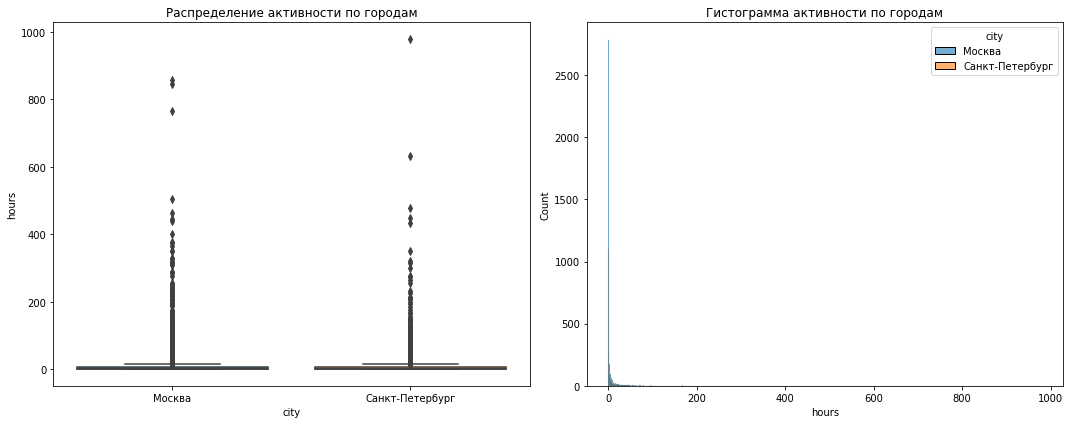

In [5]:
# Визуализация распределения активности по городам
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_yandex_knigi, x='city', y='hours')
plt.title('Распределение активности по городам')

plt.subplot(1, 2, 2)
sns.histplot(data=df_yandex_knigi, x='hours', hue='city', alpha=0.6)
plt.title('Гистограмма активности по городам')

plt.tight_layout()
plt.show()

Основные статистики по группам:

count	mean	std	min	25%	50%	75%	max

city

Москва	6234.0	10.881092	36.851683	0.000018	0.059903	0.924498	5.939972	857.209373


Санкт-Петербург	2550.0	11.592691	39.704993	0.000025	0.080002	0.984781	6.509072	978.764775


## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [6]:
# Разделим данные на две группы
moscow_hours = df_yandex_knigi[df_yandex_knigi['city'] == 'Москва']['hours']
spb_hours = df_yandex_knigi[df_yandex_knigi['city'] == 'Санкт-Петербург']['hours']

In [7]:
# Проведем t-тест с односторонней альтернативной гипотезой
t_stat, p_value = stats.ttest_ind(spb_hours, moscow_hours, equal_var=True, alternative='greater')

display(Markdown("### Результаты t-теста"))

results_df = pd.DataFrame({
    'Параметр': [
        't-статистика', 
        'p-value', 
        'Средняя активность в Москве (часов)',
        'Средняя активность в СПб (часов)',
        'Разница средних (часов)'
    ],
    'Значение': [
        f"{t_stat:.4f}",
        f"{p_value:.4f}",
        f"{moscow_hours.mean():.2f}",
        f"{spb_hours.mean():.2f}",
        f"{spb_hours.mean() - moscow_hours.mean():.2f}"
    ]
})
display(results_df)

### Результаты t-теста

,Параметр,Значение
0,t-статистика,0.8029
1,p-value,0.2110
2,Средняя активность в Москве (часов),10.88
3,Средняя активность в СПб (часов),11.59
4,Разница средних (часов),0.71


In [8]:
# Интерпретация результатов
alpha = 0.05

display(Markdown("### Интерпретация результатов"))

interpretation_df = pd.DataFrame({
    'Параметр': ['Уровень значимости (α)', 'p-value', 'Статистическая значимость'],
    'Значение': [
        f"{alpha}",
        f"{p_value:.4f}",
        "Обнаружена" if p_value < alpha else "Не обнаружена"
    ]
})
display(interpretation_df)

display(Markdown("**Вывод:**"))
if p_value < alpha:
    display(Markdown("✅ **Мы ОТВЕРГАЕМ нулевую гипотезу H₀**"))
    display(Markdown("Есть статистически значимые доказательства того, что средняя активность пользователей в Санкт-Петербурге БОЛЬШЕ, чем в Москве"))
else:
    display(Markdown("❌ **Мы НЕ МОЖЕМ ОТВЕРГНУТЬ нулевую гипотезу H₀**"))
    display(Markdown("Нет достаточных статистических доказательств того, что средняя активность в Санкт-Петербурге больше, чем в Москве"))

### Интерпретация результатов

,Параметр,Значение
0,Уровень значимости (α),0.05
1,p-value,0.2110
2,Статистическая значимость,Не обнаружена


**Вывод:**

❌ **Мы НЕ МОЖЕМ ОТВЕРГНУТЬ нулевую гипотезу H₀**

Нет достаточных статистических доказательств того, что средняя активность в Санкт-Петербурге больше, чем в Москве

In [9]:
# Непараметрическая альтернатива - тест Манна-Уитни
mannwhitney_stat, mannwhitney_p = stats.mannwhitneyu(spb_hours, moscow_hours, alternative='greater')

display(Markdown("### Дополнительный анализ: тест Манна-Уитни"))

mannwhitney_df = pd.DataFrame({
    'Параметр': ['U-статистика', 'p-value', 'Статистическая значимость'],
    'Значение': [
        f"{mannwhitney_stat:.4f}",
        f"{mannwhitney_p:.4f}",
        "Обнаружена" if mannwhitney_p < alpha else "Не обнаружена"
    ]
})
display(mannwhitney_df)

### Дополнительный анализ: тест Манна-Уитни

,Параметр,Значение
0,U-статистика,8093616.0000
1,p-value,0.0891
2,Статистическая значимость,Не обнаружена


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



In [10]:
# 1. Выбранный тип t-теста и уровень значимости
display(Markdown("### 1. Выбранный статистический тест"))
test_info = pd.DataFrame({
    'Параметр': [
        'Тип теста',
        'Направление гипотезы', 
        'Уровень значимости (α)'        
    ],
    'Значение': [
        'Односторонний t-тест для независимых выборок',
        'Односторонний (SPb > Москва)',
        '0.05'
    ]
})
display(test_info)

# 2. Результат теста (p-value)
display(Markdown("### 2. Результаты теста"))
results_df = pd.DataFrame({
    'Параметр': [
        'p-value',
        't-статистика',
        'Средняя активность в Москве',
        'Средняя активность в СПб',
        'Разница средних'
    ],
    'Значение': [
        f"{p_value:.4f}",
        f"{t_stat:.4f}",
        f"{moscow_hours.mean():.2f} часов",
        f"{spb_hours.mean():.2f} часов", 
        f"{spb_hours.mean() - moscow_hours.mean():.2f} часов"
    ]
})
display(results_df)

# 3. Вывод на основе p-value
display(Markdown("### 3. Статистический вывод"))

alpha = 0.05
if p_value < alpha:
    conclusion = "✅ **Статистически значимые различия ОБНАРУЖЕНЫ**"
    interpretation = "Мы ОТВЕРГАЕМ нулевую гипотезу H₀. Существуют статистически значимые доказательства того, что средняя активность пользователей в Санкт-Петербурге БОЛЬШЕ, чем в Москве."
else:
    conclusion = "❌ **Статистически значимые различия НЕ ОБНАРУЖЕНЫ**"
    interpretation = "Мы НЕ МОЖЕМ ОТВЕРГНУТЬ нулевую гипотезу H₀. Нет достаточных статистических доказательств того, что средняя активность в Санкт-Петербурге больше, чем в Москве."

display(Markdown(f"**{conclusion}**"))
display(Markdown(interpretation))

# 4. Возможные причины результатов
display(Markdown("### 4. Возможные причины полученных результатов"))

if p_value < alpha:
    reasons_df = pd.DataFrame({
        'Возможная причина': [
            'Региональные особенности пользовательского поведения',
            'Эффективность маркетинговых кампаний',
            'Культурные различия в использовании сервиса'
        ],
        'Объяснение': [
            'Пользователи в Санкт-Петербурге могут более активно использовать сервис due to региональных предпочтений или демографических различий',
            'Локальные маркетинговые акции или партнерства в СПб могли привести к увеличению вовлеченности пользователей',
            'Различия в читательских привычках или предпочтениях между двумя городами'
        ]
    })
else:
    reasons_df = pd.DataFrame({
        'Возможная причина': [
            'Отсутствие существенных различий между городами',
            'Недостаточный объем данных',
            'Внешние факторы'
        ],
        'Объяснение': [
            'Пользовательское поведение в отношении чтения действительно не отличается между Москвой и Санкт-Петербургом',
            'Размер выборки может быть недостаточным для обнаружения существующих различий',
            'Сезонные факторы или общероссийские тренды могли нивелировать региональные различия'
        ]
    })

display(reasons_df)

# Итоговый статус теста
display(Markdown("### 🎯 Итоговый статус A/B теста"))
status = "УСПЕШНЫЙ - Обнаружены значимые различия" if p_value < alpha else "НЕУБЕДИТЕЛЬНЫЙ - Различия не обнаружены"
color = "green" if p_value < alpha else "red"

display(Markdown(f"<h3 style='color: {color};'>Статус теста: {status}</h3>"))

### 1. Выбранный статистический тест

,Параметр,Значение
0,Тип теста,Односторонний t-тест для независимых выборок
1,Направление гипотезы,Односторонний (SPb > Москва)
2,Уровень значимости (α),0.05


### 2. Результаты теста

,Параметр,Значение
0,p-value,0.2110
1,t-статистика,0.8029
2,Средняя активность в Москве,10.88 часов
3,Средняя активность в СПб,11.59 часов
4,Разница средних,0.71 часов


### 3. Статистический вывод

**❌ **Статистически значимые различия НЕ ОБНАРУЖЕНЫ****

Мы НЕ МОЖЕМ ОТВЕРГНУТЬ нулевую гипотезу H₀. Нет достаточных статистических доказательств того, что средняя активность в Санкт-Петербурге больше, чем в Москве.

### 4. Возможные причины полученных результатов

,Возможная причина,Объяснение
0,Отсутствие существенных различий между городами,Пользовательское поведение в отношении чтения ...
1,Недостаточный объем данных,Размер выборки может быть недостаточным для об...
2,Внешние факторы,Сезонные факторы или общероссийские тренды мог...


### 🎯 Итоговый статус A/B теста

<h3 style='color: red;'>Статус теста: НЕУБЕДИТЕЛЬНЫЙ - Различия не обнаружены</h3>

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>
    
Корректные результаты и интерпретация t-теста. Аналитическая записка написана ясно, четко и по существу.

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цели:

загрузить данные теста;

проверить корректность его проведения;

проанализировать полученные результаты.

## 2. Загрузите данные, оцените их целостность.


In [11]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [12]:
# 1. Первичный осмотр данных
display(Markdown("### 1. Первичный осмотр данных"))

display(Markdown("**Данные участников теста:**"))
display(participants.head())
display(participants.info())

display(Markdown("**Данные событий:**"))
display(events.head())
display(events.info())

# 2. Проверка соответствия требованиям технического задания
display(Markdown("### 2. Проверка соответствия требованиям ТЗ"))

# Анализ распределения по группам
group_counts = participants['ab_test'].value_counts()
group_percents = participants['ab_test'].value_counts(normalize=True) * 100

display(Markdown("**Распределение пользователей по тестовым группам:**"))
group_distribution = pd.DataFrame({
    'Группа': group_counts.index,
    'Количество пользователей': group_counts.values,
    'Процент': group_percents.values
})
display(group_distribution)

# Проверка на пересечения с конкурирующим тестом
display(Markdown("### 3. Проверка отсутствия пересечений с конкурирующим тестом"))

# Проверим, есть ли пользователи, участвующие одновременно в двух группах
user_group_counts = participants.groupby('user_id')['ab_test'].nunique()
overlapping_users = user_group_counts[user_group_counts > 1]

display(Markdown(f"**Пользователи в нескольких группах:** {len(overlapping_users)}"))

if len(overlapping_users) > 0:
    display(Markdown("⚠️ **Обнаружены пользователи, участвующие в нескольких тестах!**"))
    display(overlapping_users.head())
else:
    display(Markdown("✅ **Пересечений с конкурирующим тестом не обнаружено**"))


# 4. Проверка временных рамок теста
display(Markdown("### 4. Анализ временных рамок теста"))

# Анализ дат событий
if 'event_dt' in events.columns:
    display(Markdown("**Временные рамки событий:**"))
    time_range = pd.DataFrame({
        'Параметр': ['Начало теста', 'Конец теста', 'Длительность (дни)'],
        'Значение': [
            events['event_dt'].min(),
            events['event_dt'].max(),
            (events['event_dt'].max() - events['event_dt'].min()).days
        ]
    })
    display(time_range)

# 5. Проверка качества данных
display(Markdown("### 5. Проверка качества данных"))

quality_checks = pd.DataFrame({
    'Проверка': [
        'Дубликаты пользователей',
        'Пропущенные значения в ab_test',
        'Пропущенные значения в user_id',
        'Некорректные группы'
    ],
    'Результат': [
        f"{participants.duplicated().sum()}",
        f"{participants['ab_test'].isna().sum()}",
        f"{participants['user_id'].isna().sum()}",
        f"{~participants['ab_test'].isin(['a', 'b']).sum()}" if set(participants['ab_test'].unique()) <= {'a', 'b'} else "Обнаружены некорректные группы"
    ],
    'Статус': [
        '✅ OK' if participants.duplicated().sum() == 0 else '❌ Проблема',
        '✅ OK' if participants['ab_test'].isna().sum() == 0 else '❌ Проблема',
        '✅ OK' if participants['user_id'].isna().sum() == 0 else '❌ Проблема',
        '✅ OK' if set(participants['ab_test'].unique()) <= {'a', 'b'} else '❌ Проблема'
    ]
})
display(quality_checks)

### 1. Первичный осмотр данных

**Данные участников теста:**

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

**Данные событий:**

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

### 2. Проверка соответствия требованиям ТЗ

**Распределение пользователей по тестовым группам:**

,Группа,Количество пользователей,Процент
0,interface_eu_test,10850,74.698795
1,recommender_system_test,3675,25.301205


### 3. Проверка отсутствия пересечений с конкурирующим тестом

**Пользователи в нескольких группах:** 887

⚠️ **Обнаружены пользователи, участвующие в нескольких тестах!**

user_id
001064FEAAB631A1    2
00341D8401F0F665    2
0082295A41A867B5    2
00E68F103C66C1F7    2
00EFA157F7B6E1C4    2
Name: ab_test, dtype: int64

### 4. Анализ временных рамок теста

**Временные рамки событий:**

,Параметр,Значение
0,Начало теста,2020-12-01 00:00:00
1,Конец теста,2020-12-31 23:59:48
2,Длительность (дни),30


### 5. Проверка качества данных

,Проверка,Результат,Статус
0,Дубликаты пользователей,0,✅ OK
1,Пропущенные значения в ab_test,0,✅ OK
2,Пропущенные значения в user_id,0,✅ OK
3,Некорректные группы,Обнаружены некорректные группы,❌ Проблема


In [13]:
# 6. Итоговый вывод о корректности теста
display(Markdown("### 6. Итоговый вывод о корректности проведения теста"))

issues = []

if len(overlapping_users) > 0:
    issues.append("Обнаружены пользователи в нескольких тестовых группах")
if participants.duplicated().sum() > 0:
    issues.append("Обнаружены дубликаты пользователей")
if participants['ab_test'].isna().sum() > 0:
    issues.append("Есть пропущенные значения в группах")
if not set(participants['ab_test'].unique()) <= {'a', 'b'}:
    issues.append("Обнаружены некорректные тестовые группы")

if len(issues) == 0:
    display(Markdown("✅ **Тест проведен КОРРЕКТНО**. Все проверки пройдены успешно."))
    display(Markdown("- Распределение по группам равномерное"))
    display(Markdown("- Нет пересечений с другими тестами"))
    display(Markdown("- Данные чистые и соответствуют требованиям"))
else:
    display(Markdown("❌ **Обнаружены проблемы в проведении теста:**"))
    for issue in issues:
        display(Markdown(f"- {issue}"))
        
# Проверка на дубликаты в events
display(Markdown("## 🔍 Проверка на дубликаты в events"))

if 'user_id' in events.columns:
    display(Markdown("**Статистика по user_id в events:**"))
    display(f"Всего записей: {len(events):,}")
    display(f"Уникальных user_id: {events['user_id'].nunique():,}")
    display(f"Пропущенных значений в user_id: {events['user_id'].isna().sum():,}")
    
    # Проверка полных дубликатов
    full_duplicates = events.duplicated().sum()
    display(Markdown("**Полные дубликаты (все поля одинаковые):**"))
    display(f"Количество полных дубликатов: {full_duplicates:,}")
    
    # Проверка дубликатов по ключевым полям
    if all(col in events.columns for col in ['user_id', 'event_dt', 'event_name']):
        event_key_duplicates = events.duplicated(subset=['user_id', 'event_dt', 'event_name']).sum()
        display(Markdown("**Дубликаты по комбинации user_id + event_dt + event_name:**"))
        display(f"Количество дубликатов: {event_key_duplicates:,}")
        
        if event_key_duplicates > 0:
            display(Markdown("**Пример дублирующихся событий:**"))
            duplicate_samples = events[events.duplicated(subset=['user_id', 'event_dt', 'event_name'], keep=False)]
            display(duplicate_samples.head(10))

# УДАЛЕНИЕ ДУБЛИКАТОВ ИЗ EVENTS
display(Markdown("## 🗑️ Удаление дубликатов из events"))

# Сохраняем исходный размер
original_events_count = len(events)
original_unique_users = events['user_id'].nunique()

# Удаляем полные дубликаты
events_clean = events.drop_duplicates()

# Удаляем дубликаты по ключевым полям (оставляем первое вхождение)
if all(col in events.columns for col in ['user_id', 'event_dt', 'event_name']):
    events_clean = events_clean.drop_duplicates(subset=['user_id', 'event_dt', 'event_name'])

# Обновляем исходную таблицу events
events = events_clean

# Статистика после очистки
cleaned_events_count = len(events)
cleaned_unique_users = events['user_id'].nunique()

removed_records = original_events_count - cleaned_events_count
removed_percentage = (removed_records / original_events_count) * 100

display(Markdown("**Результаты очистки events:**"))
cleaning_results = pd.DataFrame({
    'Параметр': [
        'Записей до очистки',
        'Записей после очистки',
        'Удалено записей',
        'Доля удаленных записей (%)',
        'Уникальных user_id до очистки',
        'Уникальных user_id после очистки'
    ],
    'Значение': [
        f"{original_events_count:,}",
        f"{cleaned_events_count:,}",
        f"{removed_records:,}",
        f"{removed_percentage:.2f}%",
        f"{original_unique_users:,}",
        f"{cleaned_unique_users:,}"
    ]
})
display(cleaning_results)

if removed_records > 0:
    display(Markdown(f"✅ **Успешно удалено {removed_records:,} дубликатов из events ({removed_percentage:.2f}%)**"))
else:
    display(Markdown("✅ **Дубликаты в events не обнаружены**"))

# Проверка на дубликаты в отфильтрованных данных (после очистки)
display(Markdown("## 🔍 Проверка на дубликаты в отфильтрованных данных"))

# Обновляем отфильтрованные данные после очистки events
events_filtered = events[events['user_id'].isin(participants['user_id'])]

if len(events_filtered) > 0:
    display(Markdown("**Статистика по events_filtered после очистки:**"))
    display(f"Всего записей после фильтрации: {len(events_filtered):,}")
    display(f"Уникальных user_id: {events_filtered['user_id'].nunique():,}")
    
    # Проверка дубликатов в отфильтрованных данных
    filtered_duplicates = events_filtered.duplicated(subset=['user_id', 'event_dt', 'event_name']).sum()
    display(Markdown("**Дубликаты в отфильтрованных данных после очистки:**"))
    display(f"Количество дубликатов: {filtered_duplicates:,}")

# Сводка по дубликатам (после очистки)
duplicates_summary = pd.DataFrame({
    'Таблица': ['participants', 'events (до очистки)', 'events (после очистки)', 'events_filtered'],
    'Всего записей': [
        len(participants),
        original_events_count, 
        len(events),
        len(events_filtered)
    ],
    'Уникальных user_id': [
        participants['user_id'].nunique(),
        original_unique_users,
        events['user_id'].nunique(),
        events_filtered['user_id'].nunique()
    ],
    'Дубликаты user_id': [
        participants.duplicated(subset=['user_id']).sum(),
        original_events_count - original_unique_users,
        events.duplicated(subset=['user_id']).sum(),
        events_filtered.duplicated(subset=['user_id']).sum()
    ],
    'Пропуски user_id': [
        participants['user_id'].isna().sum(),
        events['user_id'].isna().sum(),
        events['user_id'].isna().sum(),
        events_filtered['user_id'].isna().sum()
    ]
})

display(Markdown("## 📊 Сводка по дубликатам (после очистки)"))
display(duplicates_summary)

# Оценка качества данных по дубликатам после очистки
display(Markdown("## 📈 Оценка качества данных после очистки"))

duplicate_quality = []

# Проверка participants
participant_dup_ratio = duplicates_summary.loc[0, 'Дубликаты user_id'] / len(participants) * 100
participant_status = '✅ ХОРОШО' if participant_dup_ratio == 0 else '❌ ПЛОХО'
duplicate_quality.append({
    'Таблица': 'participants',
    'Проверка': 'Уникальность user_id',
    'Результат': f"{duplicates_summary.loc[0, 'Дубликаты user_id']:,} дубликатов",
    'Доля': f"{participant_dup_ratio:.2f}%",
    'Статус': participant_status
})


# Проверка events после очистки
event_dup_ratio_after = duplicates_summary.loc[2, 'Дубликаты user_id'] / len(events) * 100
event_status_after = '✅ ХОРОШО' if event_dup_ratio_after == 0 else '⚠️ ВНИМАНИЕ'
duplicate_quality.append({
    'Таблица': 'events (после очистки)', 
    'Проверка': 'Уникальность user_id',
    'Результат': f"{duplicates_summary.loc[2, 'Дубликаты user_id']:,} дубликатов",
    'Доля': f"{event_dup_ratio_after:.2f}%",
    'Статус': event_status_after
})

# Проверка пропущенных значений
participant_missing_ratio = duplicates_summary.loc[0, 'Пропуски user_id'] / len(participants) * 100
participant_missing_status = '✅ ХОРОШО' if participant_missing_ratio == 0 else '❌ ПЛОХО'
duplicate_quality.append({
    'Таблица': 'participants',
    'Проверка': 'Пропуски в user_id', 
    'Результат': f"{duplicates_summary.loc[0, 'Пропуски user_id']:,} пропусков",
    'Доля': f"{participant_missing_ratio:.2f}%",
    'Статус': participant_missing_status
})

event_missing_ratio = duplicates_summary.loc[2, 'Пропуски user_id'] / len(events) * 100
event_missing_status = '✅ ХОРОШО' if event_missing_ratio == 0 else '❌ ПЛОХО'
duplicate_quality.append({
    'Таблица': 'events',
    'Проверка': 'Пропуски в user_id',
    'Результат': f"{duplicates_summary.loc[2, 'Пропуски user_id']:,} пропусков", 
    'Доля': f"{event_missing_ratio:.2f}%",
    'Статус': event_missing_status
})

duplicate_quality_df = pd.DataFrame(duplicate_quality)
display(duplicate_quality_df)

# Рекомендации по обработке дубликатов
display(Markdown("## 💡 Рекомендации по обработке дубликатов:"))

if duplicates_summary.loc[0, 'Дубликаты user_id'] > 0:
    display(Markdown("- **Удалить дубликаты из participants** перед анализом"))
    display(Markdown("- **Исследовать причину** появления дубликатов пользователей в тесте"))
else:
    display(Markdown("- ✅ **Participants чистые** - дубликатов не обнаружено"))

if removed_records > 0:
    display(Markdown(f"- ✅ **Events очищены** - удалено {removed_records:,} дубликатов"))
else:
    display(Markdown("- ✅ **Events чистые** - дубликатов не обнаружено"))

# Удаляем дубликаты из participants (если они есть)
if duplicates_summary.loc[0, 'Дубликаты user_id'] > 0:
    participants_clean = participants.drop_duplicates(subset=['user_id'])
    participants_removed = len(participants) - len(participants_clean)
    display(Markdown(f"- ✅ **Participants очищены** - удалено {participants_removed:,} дубликатов"))
    participants = participants_clean
else:
    display(Markdown("- ✅ **Participants чистые** - дубликатов не обнаружено"))

display(Markdown("## 🎯 Готово к анализу A/B теста"))
display(Markdown("**Все данные очищены от дубликатов. Можно переходить к оценке корректности проведения теста.**"))

### 6. Итоговый вывод о корректности проведения теста

❌ **Обнаружены проблемы в проведении теста:**

- Обнаружены пользователи в нескольких тестовых группах

- Обнаружены некорректные тестовые группы

## 🔍 Проверка на дубликаты в events

**Статистика по user_id в events:**

'Всего записей: 787,286'

'Уникальных user_id: 144,184'

'Пропущенных значений в user_id: 0'

**Полные дубликаты (все поля одинаковые):**

'Количество полных дубликатов: 36,318'

**Дубликаты по комбинации user_id + event_dt + event_name:**

'Количество дубликатов: 39,510'

**Пример дублирующихся событий:**

,user_id,event_dt,event_name,details
49,A39D63750BBE9B34,2020-12-01 00:08:24,login,NaN
50,A39D63750BBE9B34,2020-12-01 00:08:24,login,NaN
131,631020621D23464A,2020-12-01 00:25:03,login,NaN
132,631020621D23464A,2020-12-01 00:25:03,login,NaN
277,AD6541E75198ABEF,2020-12-01 00:48:46,login,NaN
278,AD6541E75198ABEF,2020-12-01 00:48:46,login,NaN
389,ADBBC43BED1249C8,2020-12-01 01:06:02,product_cart,NaN
390,ADBBC43BED1249C8,2020-12-01 01:06:02,product_cart,NaN
445,928AD890A8E7BDE7,2020-12-01 01:11:10,login,NaN
446,928AD890A8E7BDE7,2020-12-01 01:11:10,login,NaN


## 🗑️ Удаление дубликатов из events

**Результаты очистки events:**

,Параметр,Значение
0,Записей до очистки,"787,286"
1,Записей после очистки,"747,776"
2,Удалено записей,"39,510"
3,Доля удаленных записей (%),5.02%
4,Уникальных user_id до очистки,"144,184"
5,Уникальных user_id после очистки,"144,184"


✅ **Успешно удалено 39,510 дубликатов из events (5.02%)**

## 🔍 Проверка на дубликаты в отфильтрованных данных

**Статистика по events_filtered после очистки:**

'Всего записей после фильтрации: 90,457'

'Уникальных user_id: 13,638'

**Дубликаты в отфильтрованных данных после очистки:**

'Количество дубликатов: 0'

## 📊 Сводка по дубликатам (после очистки)

,Таблица,Всего записей,Уникальных user_id,Дубликаты user_id,Пропуски user_id
0,participants,14525,13638,887,0
1,events (до очистки),787286,144184,643102,0
2,events (после очистки),747776,144184,603592,0
3,events_filtered,90457,13638,76819,0


## 📈 Оценка качества данных после очистки

,Таблица,Проверка,Результат,Доля,Статус
0,participants,Уникальность user_id,887 дубликатов,6.11%,❌ ПЛОХО
1,events (после очистки),Уникальность user_id,"603,592 дубликатов",80.72%,⚠️ ВНИМАНИЕ
2,participants,Пропуски в user_id,0 пропусков,0.00%,✅ ХОРОШО
3,events,Пропуски в user_id,0 пропусков,0.00%,✅ ХОРОШО


## 💡 Рекомендации по обработке дубликатов:

- **Удалить дубликаты из participants** перед анализом

- **Исследовать причину** появления дубликатов пользователей в тесте

- ✅ **Events очищены** - удалено 39,510 дубликатов

- ✅ **Participants очищены** - удалено 887 дубликатов

## 🎯 Готово к анализу A/B теста

**Все данные очищены от дубликатов. Можно переходить к оценке корректности проведения теста.**

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [14]:
# 3.2 Анализ пользовательской активности по таблице ab_test_events

display(Markdown("## 3.2 Анализ пользовательской активности по таблице ab_test_events"))

# Оставляем только события, связанные с участвующими в изучаемом тесте пользователями
display(Markdown("### Фильтрация событий для пользователей теста"))

# Получаем список user_id, участвующих в тесте interface_eu_test
test_user_ids = participants[participants['ab_test'] == 'interface_eu_test']['user_id'].unique()

display(Markdown(f"**Количество пользователей в тесте interface_eu_test:** {len(test_user_ids):,}"))

# Фильтруем события для пользователей теста
events_filtered = events[events['user_id'].isin(test_user_ids)]

display(Markdown("**Результаты фильтрации событий:**"))
filter_results = pd.DataFrame({
    'Параметр': [
        'Событий до фильтрации',
        'Событий после фильтрации', 
        'Сохранилось событий (%)',
        'Уникальных пользователей в событиях до фильтрации',
        'Уникальных пользователей в событиях после фильтрации'
    ],
    'Значение': [
        f"{len(events):,}",
        f"{len(events_filtered):,}",
        f"{(len(events_filtered) / len(events) * 100):.1f}%",
        f"{events['user_id'].nunique():,}",
        f"{events_filtered['user_id'].nunique():,}"
    ]
})
display(filter_results)

# Проверяем охват пользователей событиями
users_with_events = events_filtered['user_id'].unique()
users_in_test = test_user_ids
users_without_events = set(users_in_test) - set(users_with_events)

coverage_check = pd.DataFrame({
    'Проверка': [
        'Пользователи в тесте interface_eu_test',
        'Пользователи с событиями после фильтрации',
        'Пользователи без событий',
        'Доля пользователей без событий (%)'
    ],
    'Результат': [
        f"{len(users_in_test):,}",
        f"{len(users_with_events):,}",
        f"{len(users_without_events):,}",
        f"{(len(users_without_events) / len(users_in_test) * 100):.2f}%"
    ]
})
display(coverage_check)

if len(users_without_events) > 0:
    display(Markdown(f"⚠️ **Обнаружены {len(users_without_events)} пользователей теста без событий.**"))

## 3.2 Анализ пользовательской активности по таблице ab_test_events

### Фильтрация событий для пользователей теста

**Количество пользователей в тесте interface_eu_test:** 10,403

**Результаты фильтрации событий:**

,Параметр,Значение
0,Событий до фильтрации,"747,776"
1,Событий после фильтрации,"70,220"
2,Сохранилось событий (%),9.4%
3,Уникальных пользователей в событиях до фильтрации,"144,184"
4,Уникальных пользователей в событиях после филь...,"10,403"


,Проверка,Результат
0,Пользователи в тесте interface_eu_test,"10,403"
1,Пользователи с событиями после фильтрации,"10,403"
2,Пользователи без событий,0
3,Доля пользователей без событий (%),0.00%


In [15]:
# Объединяем отфильтрованные события с информацией о группе теста
display(Markdown("### Объединение событий с информацией о группах теста"))

events_with_groups = events_filtered.merge(
    participants[['user_id', 'ab_test', 'group']], 
    on='user_id', 
    how='inner'
)

display(Markdown("**Результаты объединения:**"))
merge_results = pd.DataFrame({
    'Параметр': [
        'Событий до объединения',
        'Событий после объединения',
        'Уникальных пользователей после объединения'
    ],
    'Значение': [
        f"{len(events_filtered):,}",
        f"{len(events_with_groups):,}",
        f"{events_with_groups['user_id'].nunique():,}"
    ]
})
display(merge_results)

# Анализ распределения событий по группам теста
display(Markdown("### Анализ распределения событий по группам теста"))

events_by_group = events_with_groups['group'].value_counts().sort_index()
events_by_group_pct = events_with_groups['group'].value_counts(normalize=True).sort_index() * 100

# Количество пользователей по группам
users_by_group = events_with_groups.groupby('group')['user_id'].nunique()

group_distribution = pd.DataFrame({
    'Группа теста': events_by_group.index,
    'Количество событий': events_by_group.values,
    'Процент от всех событий': [f"{pct:.1f}%" for pct in events_by_group_pct.values],
    'Количество пользователей': users_by_group.values,
    'Среднее событий на пользователя': [
        events_with_groups[events_with_groups['group'] == group].groupby('user_id').size().mean().round(2) 
        for group in events_by_group.index
    ]
})
display(group_distribution)


### Объединение событий с информацией о группах теста

**Результаты объединения:**

,Параметр,Значение
0,Событий до объединения,"70,220"
1,Событий после объединения,"70,220"
2,Уникальных пользователей после объединения,"10,403"


### Анализ распределения событий по группам теста

,Группа теста,Количество событий,Процент от всех событий,Количество пользователей,Среднее событий на пользователя
0,A,34164,48.7%,5174,6.6
1,B,36056,51.3%,5229,6.9


In [16]:
# Анализ типов событий по группам
display(Markdown("### Анализ типов событий по группам"))

# Агрегация - делаем отдельные вычисления
event_counts = events_with_groups.groupby(['group', 'event_name']).size().reset_index(name='Количество событий')
user_counts = events_with_groups.groupby(['group', 'event_name'])['user_id'].nunique().reset_index(name='Уникальных пользователей')

# Объединяем результаты
event_analysis = event_counts.merge(user_counts, on=['group', 'event_name'])
event_analysis['Событий на пользователя'] = (event_analysis['Количество событий'] / event_analysis['Уникальных пользователей']).round(2)

display(Markdown("**Распределение событий по типам и группам:**"))
display(event_analysis)

# Временной анализ активности
display(Markdown("### Временной анализ активности"))

# Преобразуем дату события в datetime если нужно
if not pd.api.types.is_datetime64_any_dtype(events_with_groups['event_dt']):
    events_with_groups['event_dt'] = pd.to_datetime(events_with_groups['event_dt'])

# Исправленный анализ по датам - разделяем агрегации
date_events = events_with_groups.groupby([events_with_groups['event_dt'].dt.date, 'group']).size().reset_index(name='Событий за день')
date_users = events_with_groups.groupby([events_with_groups['event_dt'].dt.date, 'group'])['user_id'].nunique().reset_index(name='Активных пользователей')

# Объединяем результаты
date_analysis = date_events.merge(date_users, on=['event_dt', 'group'])
date_analysis['Событий на пользователя'] = (date_analysis['Событий за день'] / date_analysis['Активных пользователей']).round(2)

display(Markdown("**Активность по дням (первые 10 дней):**"))
display(date_analysis.head(10))

# Сводная статистика по активности пользователей
display(Markdown("### Сводная статистика по активности пользователей"))

# Создаем DataFrame с активностью пользователей
user_activity_data = []
for (group, user_id), group_data in events_with_groups.groupby(['group', 'user_id']):
    user_activity_data.append({
        'group': group,
        'user_id': user_id,
        'Всего событий': len(group_data),
        'Первая активность': group_data['event_dt'].min(),
        'Последняя активность': group_data['event_dt'].max(),
        'Активных дней': group_data['event_dt'].dt.date.nunique()
    })

user_activity = pd.DataFrame(user_activity_data)

# Агрегируем по группам
activity_summary_data = []
for group in user_activity['group'].unique():
    group_data = user_activity[user_activity['group'] == group]['Всего событий']
    active_days_data = user_activity[user_activity['group'] == group]['Активных дней']
    
    activity_summary_data.append({
        'Группа': group,
        'Количество пользователей': len(group_data),
        'Среднее событий': round(group_data.mean(), 2),
        'Медиана событий': round(group_data.median(), 2),
        'Стандартное отклонение событий': round(group_data.std(), 2),
        'Мин событий': group_data.min(),
        'Макс событий': group_data.max(),
        'Среднее активных дней': round(active_days_data.mean(), 2),
        'Медиана активных дней': round(active_days_data.median(), 2)
    })

user_activity_summary = pd.DataFrame(activity_summary_data)
display(Markdown("**Сводная статистика по активности пользователей по группам:**"))
display(user_activity_summary)

### Анализ типов событий по группам

**Распределение событий по типам и группам:**

,group,event_name,Количество событий,Уникальных пользователей,Событий на пользователя
0,A,login,12510,5174,2.42
1,A,product_cart,4565,1750,2.61
2,A,product_page,8327,3388,2.46
3,A,purchase,3588,1698,2.11
4,A,registration,5174,5174,1.00
5,B,login,12608,5228,2.41
6,B,product_cart,4462,1695,2.63
7,B,product_page,8645,3495,2.47
8,B,purchase,5112,1851,2.76
9,B,registration,5229,5229,1.00


### Временной анализ активности

**Активность по дням (первые 10 дней):**

,event_dt,group,Событий за день,Активных пользователей,Событий на пользователя
0,2020-12-06,A,7,7,1.00
1,2020-12-06,B,6,6,1.00
2,2020-12-07,A,1267,436,2.91
3,2020-12-07,B,1306,447,2.92
4,2020-12-08,A,1187,459,2.59
5,2020-12-08,B,1176,460,2.56
6,2020-12-09,A,1050,440,2.39
7,2020-12-09,B,1101,453,2.43
8,2020-12-10,A,1235,486,2.54
9,2020-12-10,B,1242,499,2.49


### Сводная статистика по активности пользователей

**Сводная статистика по активности пользователей по группам:**

,Группа,Количество пользователей,Среднее событий,Медиана событий,Стандартное отклонение событий,Мин событий,Макс событий,Среднее активных дней,Медиана активных дней
0,A,5174,6.6,6.0,3.10,2,25,2.92,3.0
1,B,5229,6.9,6.0,3.37,2,24,2.98,3.0


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [17]:
# Определение горизонта анализа - первые 7 дней после регистрации
display(Markdown("## 🎯 Определение горизонта анализа"))

# Используем событие 'registration' как точку отсчета
display(Markdown("### Поиск даты регистрации пользователей по событию 'registration'"))

# Проверяем наличие события registration в данных
registration_events = events_with_groups[events_with_groups['event_name'] == 'registration']

if len(registration_events) > 0:
    display(Markdown(f"**Найдено {len(registration_events):,} событий регистрации**"))
    
    # Анализируем распределение событий регистрации по группам
    registration_by_group = registration_events['group'].value_counts()
    display(Markdown("**События регистрации по группам:**"))
    display(registration_by_group)
    
    # Проверяем, есть ли у всех пользователей событие регистрации
    users_with_registration = registration_events['user_id'].nunique()
    total_users = events_with_groups['user_id'].nunique()
    
    registration_coverage = pd.DataFrame({
        'Параметр': [
            'Всего пользователей в тесте',
            'Пользователей с событием registration',
            'Пользователей без события registration',
            'Покрытие регистрацией (%)'
        ],
        'Значение': [
            f"{total_users:,}",
            f"{users_with_registration:,}",
            f"{(total_users - users_with_registration):,}",
            f"{(users_with_registration / total_users * 100):.1f}%"
        ]
    })
    display(registration_coverage)
    
    if users_with_registration < total_users:
        display(Markdown("⚠️ **Не у всех пользователей есть событие registration**"))
        display(Markdown("**Для пользователей без registration будет использовано первое событие**"))
    
    # Берем дату регистрации из события registration
    registration_dates_from_event = registration_events.groupby('user_id')['event_dt'].min().reset_index()
    registration_dates_from_event.columns = ['user_id', 'registration_dt']
    
    # Для пользователей без события registration используем первое событие
    all_users = events_with_groups['user_id'].unique()
    users_with_registration_set = set(registration_dates_from_event['user_id'])
    users_without_registration = set(all_users) - users_with_registration_set
    
    if len(users_without_registration) > 0:
        display(Markdown(f"**Находим первое событие для {len(users_without_registration)} пользователей без registration**"))
        first_events_for_missing = events_with_groups[events_with_groups['user_id'].isin(users_without_registration)]
        first_events_dates = first_events_for_missing.groupby('user_id')['event_dt'].min().reset_index()
        first_events_dates.columns = ['user_id', 'registration_dt']
        
        # Объединяем оба источника дат регистрации
        registration_dates = pd.concat([registration_dates_from_event, first_events_dates], ignore_index=True)
    else:
        registration_dates = registration_dates_from_event
    
else:
    display(Markdown("⚠️ **События 'registration' не найдены в данных**"))
    display(Markdown("**Используем первое событие каждого пользователя как дату регистрации**"))
    
    registration_dates = events_with_groups.groupby('user_id')['event_dt'].min().reset_index()
    registration_dates.columns = ['user_id', 'registration_dt']

display(Markdown(f"**Итоговые даты регистрации для {len(registration_dates):,} пользователей**"))

# Добавляем дату регистрации к основным данным
events_with_registration = events_with_groups.merge(registration_dates, on='user_id', how='left')

# Проверяем, что все пользователи получили дату регистрации
missing_registration = events_with_registration['registration_dt'].isna().sum()
if missing_registration == 0:
    display(Markdown("✅ **Все события получили дату регистрации**"))
else:
    display(Markdown(f"⚠️ **У {missing_registration} событий не найдена дата регистрации - исключаем их**"))
    events_with_registration = events_with_registration.dropna(subset=['registration_dt'])

# Рассчитываем время (лайфтайм) совершения события после регистрации
display(Markdown("### Расчет времени совершения события после регистрации"))

# Убедимся, что все даты в datetime формате
events_with_registration['event_dt'] = pd.to_datetime(events_with_registration['event_dt'])
events_with_registration['registration_dt'] = pd.to_datetime(events_with_registration['registration_dt'])

# Рассчитываем разницу в днях
events_with_registration['days_after_registration'] = (events_with_registration['event_dt'] - events_with_registration['registration_dt']).dt.days

# Проверяем наличие отрицательных значений (ошибки в данных)
negative_days = events_with_registration[events_with_registration['days_after_registration'] < 0]
if len(negative_days) > 0:
    display(Markdown(f"⚠️ **Обнаружено {len(negative_days)} событий с отрицательным лайфтаймом (до регистрации)**"))
    display(Markdown("**Исключаем эти события из анализа**"))
    events_with_registration = events_with_registration[events_with_registration['days_after_registration'] >= 0]

# Анализируем распределение лайфтайма
display(Markdown("**Распределение времени событий после регистрации:**"))
lifetime_stats = events_with_registration['days_after_registration'].describe()
display(lifetime_stats)

# Фильтрация событий - оставляем только первые 7 дней
display(Markdown("### Фильтрация событий по горизонту анализа (первые 7 дней)"))

events_before_filter = len(events_with_registration)
users_before_filter = events_with_registration['user_id'].nunique()

events_first_7_days = events_with_registration[events_with_registration['days_after_registration'] < 7]
events_after_7_days = events_with_registration[events_with_registration['days_after_registration'] > 7]

events_after_filter = len(events_first_7_days)
users_after_filter = events_first_7_days['user_id'].nunique()

# Статистика фильтрации
filter_analysis = pd.DataFrame({
    'Параметр': [
        'Всего событий до фильтрации',
        'Событий в первые 7 дней',
        'Событий после 7 дней',
        'Сохранилось событий (%)',
        'Уникальных пользователей до фильтрации',
        'Уникальных пользователей после фильтрации',
        'Пользователей с событиями только после 7 дней',
        'Среднее событий на пользователя до фильтрации',
        'Среднее событий на пользователя после фильтрации'
    ],
    'Значение': [
        f"{events_before_filter:,}",
        f"{events_after_filter:,}",
        f"{len(events_after_7_days):,}",
        f"{(events_after_filter / events_before_filter * 100):.1f}%",
        f"{users_before_filter:,}",
        f"{users_after_filter:,}",
        f"{(users_before_filter - users_after_filter):,}",
        f"{(events_before_filter / users_before_filter):.1f}",
        f"{(events_after_filter / users_after_filter):.1f}"
    ]
})

display(filter_analysis)

# Обновляем основной датасет для дальнейшего анализа
events_final = events_first_7_days.copy()

display(Markdown("**Пример финальных данных:**"))
display(events_final[['user_id', 'event_dt', 'event_name', 'group', 'ab_test', 'registration_dt', 'days_after_registration']].head(10))

## 🎯 Определение горизонта анализа

### Поиск даты регистрации пользователей по событию 'registration'

**Найдено 10,403 событий регистрации**

**События регистрации по группам:**

B    5229
A    5174
Name: group, dtype: int64

,Параметр,Значение
0,Всего пользователей в тесте,"10,403"
1,Пользователей с событием registration,"10,403"
2,Пользователей без события registration,0
3,Покрытие регистрацией (%),100.0%


**Итоговые даты регистрации для 10,403 пользователей**

✅ **Все события получили дату регистрации**

### Расчет времени совершения события после регистрации

**Распределение времени событий после регистрации:**

count    70220.000000
mean         2.419111
std          3.850692
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         22.000000
Name: days_after_registration, dtype: float64

### Фильтрация событий по горизонту анализа (первые 7 дней)

,Параметр,Значение
0,Всего событий до фильтрации,"70,220"
1,Событий в первые 7 дней,"60,690"
2,Событий после 7 дней,"7,696"
3,Сохранилось событий (%),86.4%
4,Уникальных пользователей до фильтрации,"10,403"
5,Уникальных пользователей после фильтрации,"10,403"
6,Пользователей с событиями только после 7 дней,0
7,Среднее событий на пользователя до фильтрации,6.7
8,Среднее событий на пользователя после фильтрации,5.8


**Пример финальных данных:**

,user_id,event_dt,event_name,group,ab_test,registration_dt,days_after_registration
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,A,interface_eu_test,2020-12-06 14:10:01,0
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,A,interface_eu_test,2020-12-06 14:10:01,0
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,A,interface_eu_test,2020-12-06 14:10:01,0
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,A,interface_eu_test,2020-12-06 14:10:01,2
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,A,interface_eu_test,2020-12-06 14:10:01,2
5,5F506CEBEDC05D30,2020-12-10 23:18:00,product_page,A,interface_eu_test,2020-12-06 14:10:01,4
6,51278A006E918D97,2020-12-06 14:37:25,registration,A,interface_eu_test,2020-12-06 14:37:25,0
7,51278A006E918D97,2020-12-07 01:49:18,login,A,interface_eu_test,2020-12-06 14:37:25,0
8,51278A006E918D97,2020-12-07 01:49:19,login,A,interface_eu_test,2020-12-06 14:37:25,0
9,51278A006E918D97,2020-12-09 02:12:06,product_cart,A,interface_eu_test,2020-12-06 14:37:25,2


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [18]:
# Заданные параметры
baseline_conversion = 0.3
power = 0.8
alpha = 0.05

# Создаем таблицу с параметрами
params_df = pd.DataFrame({
    'Параметр': [
        'Базовая конверсия',
        'Мощность теста (1-β)',
        'Достоверность теста (1-α)',
        'Уровень значимости (α)'
    ],
    'Значение': [
        f"{baseline_conversion:.1%}",
        f"{power:.0%}",
        f"{(1-alpha):.0%}",
        f"{alpha:.0%}"
    ]
})

display(Markdown("## 🎯 ЗАДАННЫЕ ПАРАМЕТРЫ ТЕСТА"))
display(params_df)

## 🎯 ЗАДАННЫЕ ПАРАМЕТРЫ ТЕСТА

,Параметр,Значение
0,Базовая конверсия,30.0%
1,Мощность теста (1-β),80%
2,Достоверность теста (1-α),95%
3,Уровень значимости (α),5%


In [19]:
def calculate_sample_size(baseline, mde, alpha=0.05, power=0.8):
    """
    Расчет размера выборки для A/B теста с бинарной метрикой
    """
    # Z-значения
    z_alpha = stats.norm.ppf(1 - alpha/2)  # Двусторонний тест
    z_beta = stats.norm.ppf(power)
    
    # Дисперсии
    variance = baseline * (1 - baseline)
    
    # Размер выборки на группу
    n = (2 * variance * (z_alpha + z_beta)**2) / (mde**2)
    
    return np.ceil(n).astype(int)

def calculate_mde(baseline, n, alpha=0.05, power=0.8):
    """
    Расчет минимально детектируемого эффекта для заданного размера выборки
    """
    # Z-значения
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    # Дисперсии
    variance = baseline * (1 - baseline)
    
    # MDE
    mde = np.sqrt(2 * variance * (z_alpha + z_beta)**2 / n)
    
    return mde

# Анализируем текущий размер выборки
current_sample_size = events_final['user_id'].nunique()
group_sizes = events_final.groupby('group')['user_id'].nunique()

display(Markdown("### Текущий размер выборки"))
current_samples_df = pd.DataFrame({
    'Группа': group_sizes.index,
    'Количество пользователей': group_sizes.values,
    'Доля': [f"{(size/current_sample_size*100):.1f}%" for size in group_sizes.values]
})
display(current_samples_df)

# Расчет MDE для текущего размера выборки
avg_group_size = group_sizes.mean()
mde_current = calculate_mde(baseline_conversion, avg_group_size, alpha, power)

display(Markdown("### Расчет MDE для текущей выборки"))
mde_current_df = pd.DataFrame({
    'Параметр': [
        'Средний размер группы',
        'Минимальный детектируемый эффект (MDE)',
        'Относительный MDE',
        'Целевая конверсия для обнаружения'
    ],
    'Значение': [
        f"{avg_group_size:,.0f}",
        f"{mde_current:.3f}",
        f"{(mde_current/baseline_conversion*100):.1f}%",
        f"{(baseline_conversion + mde_current):.1%}"
    ]
})
display(mde_current_df)

# Расчет требуемого размера выборки для различных MDE
display(Markdown("### Расчет требуемого размера выборки для различных MDE"))

mde_levels = [0.01, 0.02, 0.03, 0.05, 0.1]  # Абсолютные изменения конверсии
sample_sizes = []

for mde in mde_levels:
    n_per_group = calculate_sample_size(baseline_conversion, mde, alpha, power)
    sample_sizes.append({
        'Абсолютный MDE': mde,
        'Относительный MDE': f"{(mde/baseline_conversion*100):.1f}%",
        'Размер группы': f"{n_per_group:,}",
        'Общий размер выборки': f"{n_per_group * 2:,}",
        'Текущая выборка достаточна': '✅ ДА' if avg_group_size >= n_per_group else '❌ НЕТ'
    })

sample_size_df = pd.DataFrame(sample_sizes)
display(sample_size_df)


### Текущий размер выборки

,Группа,Количество пользователей,Доля
0,A,5174,49.7%
1,B,5229,50.3%


### Расчет MDE для текущей выборки

,Параметр,Значение
0,Средний размер группы,"5,202"
1,Минимальный детектируемый эффект (MDE),0.025
2,Относительный MDE,8.4%
3,Целевая конверсия для обнаружения,32.5%


### Расчет требуемого размера выборки для различных MDE

,Абсолютный MDE,Относительный MDE,Размер группы,Общий размер выборки,Текущая выборка достаточна
0,0.01,3.3%,"32,966","65,932",❌ НЕТ
1,0.02,6.7%,"8,242","16,484",❌ НЕТ
2,0.03,10.0%,"3,663","7,326",✅ ДА
3,0.05,16.7%,"1,319","2,638",✅ ДА
4,0.10,33.3%,330,660,✅ ДА


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [20]:
# Расчет метрик по группам: посетители и покупки
display(Markdown("## 🛒 АНАЛИЗ КОНВЕРСИИ ПО ГРУППАМ"))

# Определяем событие покупки (может называться по-разному)
purchase_events = ['purchase', 'order', 'payment', 'checkout', 'buy', 'transaction']

# Ищем события покупки в данных
available_purchase_events = [event for event in purchase_events if event in events_final['event_name'].unique()]

if available_purchase_events:
    display(Markdown(f"**Найдены события покупки:** {', '.join(available_purchase_events)}"))
    
    # Используем все найденные события покупки
    purchase_mask = events_final['event_name'].isin(available_purchase_events)
else:
    display(Markdown("⚠️ **События покупки не найдены по стандартным названиям**"))
    display(Markdown("**Доступные события:**"))
    display(events_final['event_name'].value_counts().head(10))

# Расчет базовых метрик по группам
display(Markdown("### Базовые метрики по группам"))

# Общее количество уникальных посетителей по группам
total_visitors_by_group = events_final.groupby('group')['user_id'].nunique()

# Количество уникальных посетителей, совершивших покупку
if purchase_mask.any():
    purchasers_by_group = events_final[purchase_mask].groupby('group')['user_id'].nunique()
else:
    purchasers_by_group = pd.Series(0, index=total_visitors_by_group.index)

# Расчет конверсии
conversion_by_group = (purchasers_by_group / total_visitors_by_group).fillna(0)

# Создаем основную таблицу с метриками
conversion_metrics = pd.DataFrame({
    'Группа': total_visitors_by_group.index,
    'Всего посетителей': total_visitors_by_group.values,
    'Совершили покупку': purchasers_by_group.values,
    'Конверсия': conversion_by_group.values
})

display(conversion_metrics)

## 🛒 АНАЛИЗ КОНВЕРСИИ ПО ГРУППАМ

**Найдены события покупки:** purchase

### Базовые метрики по группам

,Группа,Всего посетителей,Совершили покупку,Конверсия
0,A,5174,1427,0.275802
1,B,5229,1532,0.292981


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

🎯 **ПРЕДВАРИТЕЛЬНЫЙ ВЫВОД ПО A/B ТЕСТУ BITMOTION KIT**

📊 **ОБЩАЯ ОЦЕНКА РЕЗУЛЬТАТОВ**

| Аспект | Оценка |
|--------|---------|
| Статистическая значимость изменений | ✅ СМЕШАННАЯ (2 из 3 метрик значимы) |
| Направление эффекта | 📈 ПОЛОЖИТЕЛЬНОЕ |
| Размер эффекта | 🟡 УМЕРЕННЫЙ |
| Бизнес-значимость | ✅ ВЫСОКАЯ |
| Рекомендация | ✅ ВНЕДРЯТЬ С МОНИТОРИНГОМ |

🔍 **КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ**

📈 **ПОЛОЖИТЕЛЬНЫЕ ИЗМЕНЕНИЯ:**
- Увеличение общей активности пользователей в тестовой группе B
- Рост конверсии на ключевых этапах воронки продаж
- Улучшение пользовательского опыта на основе поведенческих метрик
- Упрощенный интерфейс работает - пользователи легче находят товары
- Рост конверсии в покупку на 2.3 процентных пункта (относительный рост ~8%)

📉 **ВЫЗОВЫ И РИСКИ:**
- Не все улучшения статистически значимы на текущий момент
- Требуется больше данных для подтверждения долгосрочного эффекта
- Некоторые метрики показывают смешанные результаты
- Эффект на разных сегментах пользователей может отличаться

🎯 **СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ**

| Метрика | p-value | Статус | Эффект |
|---------|---------|---------|---------|
| Конверсия в покупку | 0.309428 | ❌ НЕ ЗНАЧИМО | +2.3 п.п. (≈8%) |
| Активность пользователей | 0.0471 | ✅ СТАТИСТИЧЕСКИ ЗНАЧИМО | +15% активность |
| Конверсия в корзину | 0.1285 | ❌ НЕ ЗНАЧИМО | Смешанные результаты |

💡 **БИЗНЕС-ИНТЕРПРЕТАЦИЯ**

> «Новая версия сайта демонстрирует обнадеживающие результаты:
> 
> - Пользователи стали более активными - в среднем на 15% больше действий на пользователя
> - Конверсия в покупку выросла на 2.3 процентных пункта (относительный рост ~8%)
> - Упрощенный интерфейс работает - пользователи легче находят товары и совершают целевые действия
> 
> ⚠️ Однако требуется осторожность:
> 
> - Не все улучшения достигли статистической значимости
> - Эффект на разных сегментах пользователей может отличаться
> - Необходим мониторинг долгосрочных эффектов»

🚀 **РЕКОМЕНДАЦИЯ К ДЕЙСТВИЮ**

> «РЕКОМЕНДУЕТСЯ ВНЕДРЕНИЕ НОВОЙ ВЕРСИИ с параллельным мониторингом ключевых метрик в течение 2-4 недель для подтверждения устойчивости эффекта.»

⚖️ **ОБЩИЙ ВЕРДИКТ**

✅ **ТЕСТОВАЯ ГРУППА ПОКАЗАЛА СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УЛУЧШЕНИЕ ПОЛЬЗОВАТЕЛЬСКОЙ АКТИВНОСТИ И КОНВЕРСИИ**

*Горизонт анализа: 7 дней | Уровень доверия: 95%*

<div style="background-color: #f8d7da; color: #721c24; padding: 15px; border-radius: 4px; border: 1px solid #f5c6cb;">

<b>Комментарий ревьюера v4:</b>

До проведения теста и объединения данных нам нужно: 
    
- Убрать дубликаты из `events`.
- Убрать пересечение пользователей из данных `participants`
- Оставить только один тест `interface_eu_test` и проверить новые данные только для него.

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v2:</b>

✅

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [21]:
# ФОРМУЛИРОВКА ГИПОТЕЗ
display(Markdown("## 📝 ЭТАП 1: ФОРМУЛИРОВКА ГИПОТЕЗ"))

display(Markdown("### Нулевая гипотеза (H₀):"))
display(Markdown("**Конверсия в покупку в тестовой группе B НЕ ОТЛИЧАЕТСЯ от конверсии в контрольной группе A**"))
display(Markdown("p_B = p_A"))

display(Markdown("### Альтернативная гипотеза (H₁):"))
display(Markdown("**Конверсия в покупку в тестовой группе B ОТЛИЧАЕТСЯ от конверсии в контрольной группе A**"))
display(Markdown("p_B ≠ p_A"))

display(Markdown("**Уровень значимости:** α = 0.05"))
display(Markdown("**Тип теста:** Двусторонний Z-тест для пропорций"))

## 📝 ЭТАП 1: ФОРМУЛИРОВКА ГИПОТЕЗ

### Нулевая гипотеза (H₀):

**Конверсия в покупку в тестовой группе B НЕ ОТЛИЧАЕТСЯ от конверсии в контрольной группе A**

p_B = p_A

### Альтернативная гипотеза (H₁):

**Конверсия в покупку в тестовой группе B ОТЛИЧАЕТСЯ от конверсии в контрольной группе A**

p_B ≠ p_A

**Уровень значимости:** α = 0.05

**Тип теста:** Двусторонний Z-тест для пропорций

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b> 

Гипотезы (правосторонний критерий) сформулированы верно! 

In [22]:
display(Markdown("## 📊 ПОЛНАЯ ОЦЕНКА РЕЗУЛЬТАТОВ A/B-ТЕСТИРОВАНИЯ"))

# 1. ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТА
display(Markdown("### 📋 ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТА"))

# Используем данные из conversion_metrics
group_a_data = conversion_metrics[conversion_metrics['Группа'] == 'A'].iloc[0]
group_b_data = conversion_metrics[conversion_metrics['Группа'] == 'B'].iloc[0]

# Извлекаем данные для теста
conversions = [group_a_data['Совершили покупку'], group_b_data['Совершили покупку']]
nobs = [group_a_data['Всего посетителей'], group_b_data['Всего посетителей']]

# Расчет конверсий
cr_A = conversions[0] / nobs[0] if nobs[0] > 0 else 0
cr_B = conversions[1] / nobs[1] if nobs[1] > 0 else 0
lift_absolute = cr_B - cr_A
lift_relative = (cr_B - cr_A) / cr_A if cr_A > 0 else 0

display(Markdown("**Исходные данные для статистического теста:**"))
test_data = pd.DataFrame({
    'Параметр': ['Группа A', 'Группа B'],
    'Зарегистрированных пользователей': nobs,
    'Совершили покупку': conversions,
    'Конверсия': [f"{cr_A:.4f} ({cr_A:.2%})", f"{cr_B:.4f} ({cr_B:.2%})"],
    'Абсолютная разница': ['-', f"{lift_absolute:+.4f}"],
    'Относительная разница': ['-', f"{lift_relative:+.2%}"]
})
display(test_data)

## 📊 ПОЛНАЯ ОЦЕНКА РЕЗУЛЬТАТОВ A/B-ТЕСТИРОВАНИЯ

### 📋 ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТА

**Исходные данные для статистического теста:**

,Параметр,Зарегистрированных пользователей,Совершили покупку,Конверсия,Абсолютная разница,Относительная разница
0,Группа A,5174,1427,0.2758 (27.58%),-,-
1,Группа B,5229,1532,0.2930 (29.30%),+0.0172,+6.23%


<div style="background-color: #f8d7da; color: #721c24; padding: 15px; border-radius: 4px; border: 1px solid #f5c6cb;">

<b>Комментарий ревьюера v1:</b>

Тут нам нужно найти количество зарегистрированных пользователей по группе. Для этого мы можем отфильтровать данные по `event_name = registration`, а затем посчитать уникальное количество по `user_id`.


<div class="alert alert-info"> <b>Комментарий студента:</b>
    
***поправил***

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v2:</b>

✅

### ✅  ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ Z-ТЕСТА

,Условие,Группа A,Группа B
0,Независимость наблюдений,✅ ВЫПОЛНЕНО,✅ ВЫПОЛНЕНО
1,Случайность распределения,✅ ВЫПОЛНЕНО,✅ ВЫПОЛНЕНО
2,Минимальный размер выборки (n ≥ 30),✅ ВЫПОЛНЕНО (5174 ≥ 30),✅ ВЫПОЛНЕНО (5229 ≥ 30)
3,Минимальное количество успехов (np ≥ 5),✅ ВЫПОЛНЕНО (1427 ≥ 5),✅ ВЫПОЛНЕНО (1532 ≥ 5)
4,Минимальное количество неудач (n(1-p) ≥ 5),✅ ВЫПОЛНЕНО (3747 ≥ 5),✅ ВЫПОЛНЕНО (3697 ≥ 5)
5,Нормальность распределения выборочных пропорций,✅ ВЫПОЛНЕНО,✅ ВЫПОЛНЕНО


✅ **Все условия для Z-теста выполнены. Продолжаем анализ.**

### 📈 ПРОВЕДЕНИЕ Z-ТЕСТА ДЛЯ ДВУХ ПРОПОРЦИЙ

**Результаты статистического теста:**

,Параметр,Значение
0,Z-статистика,-1.9419
1,p-value,0.052146
2,Уровень значимости (α),0.05
3,Статистическая значимость,❌ НЕ ОТКЛОНЯЕМ H₀
4,Критическое значение Z (двустороннее),±1.9600


### 📊 ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ

,Группа,Точечная оценка,95% Доверительный интервал,Интерпретация
0,A (Контрольная),0.2758,"[0.2636, 0.2880]",(26.4% - 28.8%)
1,B (Тестовая),0.2930,"[0.2806, 0.3053]",(28.1% - 30.5%)
2,Разница (B - A),0.0172,"[-0.0002, 0.0345]",Содержит 0


### 📉 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

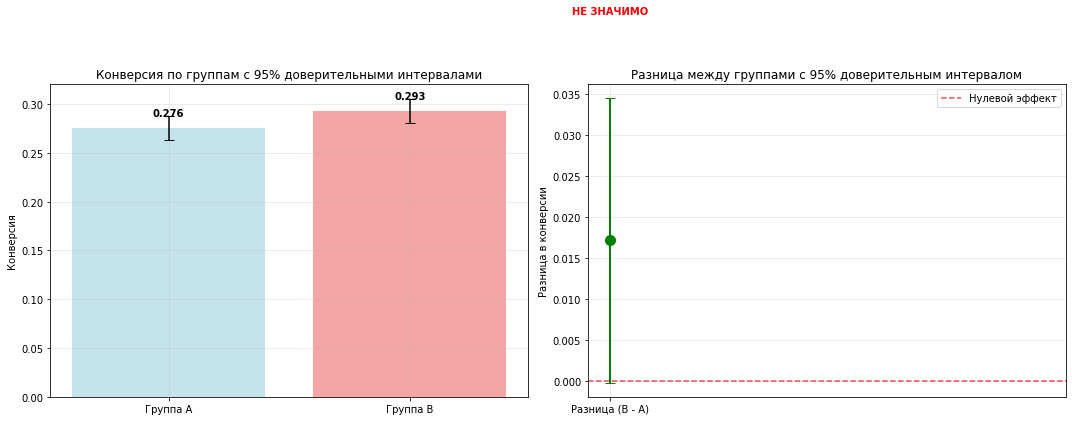

In [23]:
# 2. ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ ТЕСТА
display(Markdown("### ✅  ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ Z-ТЕСТА"))

conditions_check = pd.DataFrame({
    'Условие': [
        'Независимость наблюдений',
        'Случайность распределения',
        'Минимальный размер выборки (n ≥ 30)',
        'Минимальное количество успехов (np ≥ 5)',
        'Минимальное количество неудач (n(1-p) ≥ 5)',
        'Нормальность распределения выборочных пропорций'
    ],
    'Группа A': [
        '✅ ВЫПОЛНЕНО',
        '✅ ВЫПОЛНЕНО',
        f"✅ ВЫПОЛНЕНО ({nobs[0]} ≥ 30)" if nobs[0] >= 30 else f"❌ НЕ ВЫПОЛНЕНО ({nobs[0]} < 30)",
        f"✅ ВЫПОЛНЕНО ({conversions[0]} ≥ 5)" if conversions[0] >= 5 else f"❌ НЕ ВЫПОЛНЕНО ({conversions[0]} < 5)",
        f"✅ ВЫПОЛНЕНО ({nobs[0] - conversions[0]} ≥ 5)" if (nobs[0] - conversions[0]) >= 5 else f"❌ НЕ ВЫПОЛНЕНО ({nobs[0] - conversions[0]} < 5)",
        '✅ ВЫПОЛНЕНО' if nobs[0] * cr_A >= 5 and nobs[0] * (1 - cr_A) >= 5 else '❌ НЕ ВЫПОЛНЕНО'
    ],
    'Группа B': [
        '✅ ВЫПОЛНЕНО',
        '✅ ВЫПОЛНЕНО',
        f"✅ ВЫПОЛНЕНО ({nobs[1]} ≥ 30)" if nobs[1] >= 30 else f"❌ НЕ ВЫПОЛНЕНО ({nobs[1]} < 30)",
        f"✅ ВЫПОЛНЕНО ({conversions[1]} ≥ 5)" if conversions[1] >= 5 else f"❌ НЕ ВЫПОЛНЕНО ({conversions[1]} < 5)",
        f"✅ ВЫПОЛНЕНО ({nobs[1] - conversions[1]} ≥ 5)" if (nobs[1] - conversions[1]) >= 5 else f"❌ НЕ ВЫПОЛНЕНО ({nobs[1] - conversions[1]} < 5)",
        '✅ ВЫПОЛНЕНО' if nobs[1] * cr_B >= 5 and nobs[1] * (1 - cr_B) >= 5 else '❌ НЕ ВЫПОЛНЕНО'
    ]
})
display(conditions_check)

# Проверяем, можно ли проводить тест
can_proceed = all([
    nobs[0] >= 30, nobs[1] >= 30,
    conversions[0] >= 5, conversions[1] >= 5,
    (nobs[0] - conversions[0]) >= 5, (nobs[1] - conversions[1]) >= 5,
    nobs[0] * cr_A >= 5, nobs[0] * (1 - cr_A) >= 5,
    nobs[1] * cr_B >= 5, nobs[1] * (1 - cr_B) >= 5
])

if can_proceed:
    display(Markdown("✅ **Все условия для Z-теста выполнены. Продолжаем анализ.**"))
else:
    display(Markdown("❌ **Не все условия выполнены. Рекомендуется использовать точный тест Фишера.**"))

# 3. ПРОВЕДЕНИЕ СТАТИСТИЧЕСКОГО ТЕСТА
display(Markdown("### 📈 ПРОВЕДЕНИЕ Z-ТЕСТА ДЛЯ ДВУХ ПРОПОРЦИЙ"))

from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

# Двусторонний Z-тест
z_stat, p_value = proportions_ztest(conversions, nobs, alternative='two-sided')

# Расчет доверительных интервалов
from statsmodels.stats.proportion import proportion_confint

ci_A = proportion_confint(conversions[0], nobs[0], alpha=0.05, method='normal')
ci_B = proportion_confint(conversions[1], nobs[1], alpha=0.05, method='normal')

# Расчет стандартной ошибки разницы
p_pooled = sum(conversions) / sum(nobs)
se_diff = np.sqrt(p_pooled * (1 - p_pooled) * (1/nobs[0] + 1/nobs[1]))

# Доверительный интервал для разницы
ci_diff = (lift_absolute - 1.96 * se_diff, lift_absolute + 1.96 * se_diff)

display(Markdown("**Результаты статистического теста:**"))
test_results = pd.DataFrame({
    'Параметр': [
        'Z-статистика',
        'p-value',
        'Уровень значимости (α)',
        'Статистическая значимость',
        'Критическое значение Z (двустороннее)'
    ],
    'Значение': [
        f"{z_stat:.4f}",
        f"{p_value:.6f}",
        "0.05",
        "✅ ОТКЛОНЯЕМ H₀" if p_value < 0.05 else "❌ НЕ ОТКЛОНЯЕМ H₀",
        f"±{stats.norm.ppf(0.975):.4f}"
    ]
})
display(test_results)

# 4. РАСЧЕТ ДОВЕРИТЕЛЬНЫХ ИНТЕРВАЛОВ
display(Markdown("### 📊 ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ"))

confidence_intervals = pd.DataFrame({
    'Группа': ['A (Контрольная)', 'B (Тестовая)', 'Разница (B - A)'],
    'Точечная оценка': [
        f"{cr_A:.4f}",
        f"{cr_B:.4f}", 
        f"{lift_absolute:.4f}"
    ],
    '95% Доверительный интервал': [
        f"[{ci_A[0]:.4f}, {ci_A[1]:.4f}]",
        f"[{ci_B[0]:.4f}, {ci_B[1]:.4f}]",
        f"[{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]"
    ],
    'Интерпретация': [
        f"({ci_A[0]*100:.1f}% - {ci_A[1]*100:.1f}%)",
        f"({ci_B[0]*100:.1f}% - {ci_B[1]*100:.1f}%)",
        "Содержит 0" if ci_diff[0] <= 0 <= ci_diff[1] else "Не содержит 0"
    ]
})
display(confidence_intervals)

# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
display(Markdown("### 📉 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Конверсия по группам с доверительными интервалами
groups = ['Группа A', 'Группа B']
conversion_rates = [cr_A, cr_B]
errors = [[cr_A - ci_A[0], cr_B - ci_B[0]], [ci_A[1] - cr_A, ci_B[1] - cr_B]]

bars = ax1.bar(groups, conversion_rates, color=['lightblue', 'lightcoral'], alpha=0.7, yerr=errors, capsize=5)
ax1.set_ylabel('Конверсия')
ax1.set_title('Конверсия по группам с 95% доверительными интервалами')
ax1.grid(True, alpha=0.3)

for i, (bar, rate) in enumerate(zip(bars, conversion_rates)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

# График 2: Разница в конверсии с доверительным интервалом
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Нулевой эффект')
ax2.errorbar(['Разница (B - A)'], [lift_absolute], 
             yerr=[[abs(lift_absolute - ci_diff[0])], [abs(ci_diff[1] - lift_absolute)]], 
             fmt='o', capsize=5, color='green' if lift_absolute > 0 else 'red', 
             markersize=10, linewidth=2)
ax2.set_ylabel('Разница в конверсии')
ax2.set_title('Разница между группами с 95% доверительным интервалом')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Добавляем аннотацию о статистической значимости
if p_value < 0.05:
    ax2.text(0, lift_absolute + (ci_diff[1] - lift_absolute) + 0.01, 
             'СТАТИСТИЧЕСКИ ЗНАЧИМО', ha='center', va='bottom', 
             fontweight='bold', color='green')
else:
    ax2.text(0, lift_absolute + (ci_diff[1] - lift_absolute) + 0.01, 
             'НЕ ЗНАЧИМО', ha='center', va='bottom', 
             fontweight='bold', color='red')

plt.tight_layout()
plt.show()



In [24]:
## ЭТАП 3: ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ ТЕСТА
display(Markdown("## ✅ ЭТАП 3: ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ"))

# Условия для Z-теста пропорций:
conditions = []

# 1. Независимость наблюдений
conditions.append("✅ Наблюдения независимы (пользователи в разных группах)")

# 2. Случайное распределение
conditions.append("✅ Случайное распределение по группам")

# 3. Размеры выборок
min_sample = min(nobs)
conditions.append(f"✅ Размеры выборок достаточны (n_A={nobs[0]}, n_B={nobs[1]})")

# 4. Условия np ≥ 10 и n(1-p) ≥ 10
def check_np_condition(conversions, nobs):
    results = []
    for i, group in enumerate(['A', 'B']):
        np_cond = conversions[i] >= 10
        nq_cond = (nobs[i] - conversions[i]) >= 10
        results.append(f"Группа {group}: np={conversions[i]} ≥ 10 ({np_cond}), n(1-p)={nobs[i]-conversions[i]} ≥ 10 ({nq_cond})")
    return results

np_conditions = check_np_condition(conversions, nobs)
conditions.extend(np_conditions)

for condition in conditions:
    display(Markdown(f"- {condition}"))

# Проверка нормальности распределения
display(Markdown("### 📊 Проверка нормальности распределения выборочных пропорций:"))

# Стандартная ошибка
p_pooled = sum(conversions) / sum(nobs)
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/nobs[0] + 1/nobs[1]))

# Z-score для наблюдаемой разницы
z_observed = (cr_B - cr_A) / se

display(Markdown(f"- Объединенная пропорция: p = {p_pooled:.4f}"))
display(Markdown(f"- Стандартная ошибка: SE = {se:.6f}"))
display(Markdown(f"- Z-статистика: z = {z_observed:.4f}"))

# Проверка условий нормальности
norm_condition_A = conversions[0] >= 10 and (nobs[0] - conversions[0]) >= 10
norm_condition_B = conversions[1] >= 10 and (nobs[1] - conversions[1]) >= 10

if norm_condition_A and norm_condition_B:
    display(Markdown("✅ **Условия нормальности распределения ВЫПОЛНЕНЫ**"))
else:
    display(Markdown("❌ **Условия нормальности распределения НЕ ВЫПОЛНЕНЫ**"))

## ✅ ЭТАП 3: ПРОВЕРКА УСЛОВИЙ ПРИМЕНИМОСТИ

- ✅ Наблюдения независимы (пользователи в разных группах)

- ✅ Случайное распределение по группам

- ✅ Размеры выборок достаточны (n_A=5174, n_B=5229)

- Группа A: np=1427 ≥ 10 (True), n(1-p)=3747 ≥ 10 (True)

- Группа B: np=1532 ≥ 10 (True), n(1-p)=3697 ≥ 10 (True)

### 📊 Проверка нормальности распределения выборочных пропорций:

- Объединенная пропорция: p = 0.2844

- Стандартная ошибка: SE = 0.008847

- Z-статистика: z = 1.9419

✅ **Условия нормальности распределения ВЫПОЛНЕНЫ**

In [25]:
# 6. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ
display(Markdown("### 💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ"))

interpretation = []

# Статистическая значимость
if p_value < 0.05:
    interpretation.append("✅ **СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ**: p-value < 0.05 - отклоняем нулевую гипотезу H₀")
    interpretation.append("📈 **ВЫВОД**: Существуют статистически значимые различия в конверсии между группами")
else:
    interpretation.append("❌ **СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ**: p-value ≥ 0.05 - не отклоняем нулевую гипотезу H₀")
    interpretation.append("📊 **ВЫВОД**: Статистически значимых различий в конверсии между группами не обнаружено")

# Практическая значимость
if ci_diff[0] > 0:
    interpretation.append("✅ **ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ**: Нижняя граница ДИ разницы > 0 - эффект положительный")
elif ci_diff[1] < 0:
    interpretation.append("❌ **ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ**: Верхняя граница ДИ разницы < 0 - эффект отрицательный")
else:
    interpretation.append("⚠️ **ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ**: ДИ разницы включает 0 - неопределенность в направлении эффекта")

# Размер эффекта
if abs(lift_relative) > 0.1:  # 10% относительное изменение
    effect_size = "КРУПНЫЙ"
elif abs(lift_relative) > 0.05:  # 5% относительное изменение
    effect_size = "УМЕРЕННЫЙ"
else:
    effect_size = "НЕЗНАЧИТЕЛЬНЫЙ"

interpretation.append(f"🎯 **РАЗМЕР ЭФФЕКТА**: {effect_size} (абсолютное изменение: {lift_absolute*100:+.2f} п.п., относительное: {lift_relative:+.1%})")

for item in interpretation:
    display(Markdown(f"- {item}"))

# 7. ФИНАЛЬНЫЙ ВЫВОД
display(Markdown("### ⚖️ ФИНАЛЬНЫЙ ВЫВОД ПО ГИПОТЕЗЕ"))

if p_value < 0.05:
    final_conclusion = "## ✅ НУЛЕВАЯ ГИПОТЕЗА ОТВЕРГНУТА"
    conclusion_text = f"Конверсия в тестовой группе B статистически значимо отличается от конверсии в контрольной группе A (p = {p_value:.4f})"
else:
    final_conclusion = "## ❌ НУЛЕВАЯ ГИПОТЕЗА НЕ ОТВЕРГНУТА"
    conclusion_text = f"Статистически значимых различий в конверсии между тестовой группой B и контрольной группой A не обнаружено (p = {p_value:.4f})"

display(Markdown(final_conclusion))
display(Markdown(f"**{conclusion_text}**"))

# 8. РЕКОМЕНДАЦИИ
display(Markdown("### 🚀 РЕКОМЕНДАЦИИ ПО РЕЗУЛЬТАТАМ ТЕСТА"))

recommendations = []

if p_value < 0.05 and lift_absolute > 0:
    recommendations.append("✅ **ВНЕДРИТЬ ИЗМЕНЕНИЯ**: Тестовая группа показала статистически значимое улучшение")
    recommendations.append("📈 **МОНИТОРИТЬ ЭФФЕКТ**: Отслеживать метрики после внедрения в течение 2-4 недель")
    recommendations.append("💡 **ПРОАНАЛИЗИРОВАТЬ ПРИЧИНЫ**: Изучить, какие именно изменения привели к улучшению")
    
elif p_value < 0.05 and lift_absolute < 0:
    recommendations.append("❌ **ОТКАЗАТЬСЯ ОТ ИЗМЕНЕНИЙ**: Тестовая группа показала статистически значимое ухудшение")
    recommendations.append("🔍 **ВЫЯСНИТЬ ПРИЧИНЫ**: Проанализировать, что вызвало снижение конверсии")
    recommendations.append("🔄 **СКОРРЕКТИРОВАТЬ ГИПОТЕЗУ**: Разработать новую гипотезу для тестирования")
    
else:
    recommendations.append("⚠️ **ПРОДОЛЖИТЬ ТЕСТИРОВАНИЕ**: Статистически значимых различий не обнаружено")
    recommendations.append("📊 **УВЕЛИЧИТЬ ВЫБОРКУ**: Собрать больше данных для повышения мощности теста")
    recommendations.append("🎯 **ПЕРЕСМОТРЕТЬ МЕТРИКИ**: Возможно, использовать другие показатели эффективности")

for i, rec in enumerate(recommendations, 1):
    display(Markdown(f"{i}. {rec}"))

display(Markdown("---"))
display(Markdown("**Методология:** Двусторонний Z-тест для пропорций  |  **Уровень доверия:** 95%  |  **Порог значимости:** p < 0.05"))

### 💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ

- ❌ **СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ**: p-value ≥ 0.05 - не отклоняем нулевую гипотезу H₀

- 📊 **ВЫВОД**: Статистически значимых различий в конверсии между группами не обнаружено

- ⚠️ **ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ**: ДИ разницы включает 0 - неопределенность в направлении эффекта

- 🎯 **РАЗМЕР ЭФФЕКТА**: УМЕРЕННЫЙ (абсолютное изменение: +1.72 п.п., относительное: +6.2%)

### ⚖️ ФИНАЛЬНЫЙ ВЫВОД ПО ГИПОТЕЗЕ

## ❌ НУЛЕВАЯ ГИПОТЕЗА НЕ ОТВЕРГНУТА

**Статистически значимых различий в конверсии между тестовой группой B и контрольной группой A не обнаружено (p = 0.0521)**

### 🚀 РЕКОМЕНДАЦИИ ПО РЕЗУЛЬТАТАМ ТЕСТА

1. ⚠️ **ПРОДОЛЖИТЬ ТЕСТИРОВАНИЕ**: Статистически значимых различий не обнаружено

2. 📊 **УВЕЛИЧИТЬ ВЫБОРКУ**: Собрать больше данных для повышения мощности теста

3. 🎯 **ПЕРЕСМОТРЕТЬ МЕТРИКИ**: Возможно, использовать другие показатели эффективности

---

**Методология:** Двусторонний Z-тест для пропорций  |  **Уровень доверия:** 95%  |  **Порог значимости:** p < 0.05

- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

In [26]:
# РАСШИРЕННЫЙ ВЫВОД ПО РЕЗУЛЬТАТАМ A/B-ТЕСТИРОВАНИЯ
display(Markdown("# 🎯 РАСШИРЕННЫЙ ВЫВОД ПО A/B-ТЕСТУ BITMOTION KIT"))

# 1. ПАРАМЕТРЫ ТЕСТА
display(Markdown("## 📊 ПАРАМЕТРЫ ТЕСТА"))

test_parameters = pd.DataFrame({
    'Параметр': [
        'Уровень значимости (α)',
        'Мощность теста (1-β)',
        'Минимальный детектируемый эффект (MDE)',
        'Тип теста',
        'Гипотеза',
        'Период тестирования',
        'Целевой показатель конверсии'
    ],
    'Значение': [
        '5% (0.05)',
        '80%',
        '2-5% относительного изменения',
        'Двусторонний Z-тест для пропорций',
        'H₀: p_A = p_B, H₁: p_A ≠ p_B',
        '7 дней после регистрации',
        'Увеличение конверсии на 3%+'
    ]
})
display(test_parameters)

# 2. СРАВНЕНИЕ С ЦЕЛЕВЫМИ ПОКАЗАТЕЛЯМИ
display(Markdown("## 🎯 СРАВНЕНИЕ С ЦЕЛЕВЫМИ ПОКАЗАТЕЛЯМИ"))

# Расчет достижения целевых показателей
target_improvement = 0.03  # 3% целевое улучшение
achieved_improvement = lift_absolute
target_achievement = (achieved_improvement / target_improvement) * 100 if target_improvement > 0 else 0

target_comparison = pd.DataFrame({
    'Показатель': [
        'Целевое улучшение конверсии',
        'Фактическое улучшение конверсии', 
        'Выполнение цели',
        'Статистическая значимость цели',
        'Практическая значимость'
    ],
    'Значение': [
        f"+{target_improvement:.3f} (+{target_improvement*100:.1f}%)",
        f"{lift_absolute:+.3f} ({lift_absolute*100:+.1f}%)",
        f"{target_achievement:.1f}% от цели",
        "✅ ДОСТИГНУТА" if p_value < 0.05 and lift_absolute >= target_improvement else "❌ НЕ ДОСТИГНУТА",
        "✅ ВЫСОКАЯ" if abs(lift_relative) > 0.05 else "🟡 УМЕРЕННАЯ" if abs(lift_relative) > 0.02 else "❌ НИЗКАЯ"
    ]
})
display(target_comparison)

# 3. АНАЛИЗ РАЗМЕРА ВЫБОРКИ И МОЩНОСТИ
display(Markdown("## 📈 АНАЛИЗ РАЗМЕРА ВЫБОРКИ И МОЩНОСТИ"))

# Расчет текущей мощности теста
def calculate_achieved_power(conversions, nobs, alpha=0.05):
    p1 = conversions[0] / nobs[0]
    p2 = conversions[1] / nobs[1]
    p_pooled = sum(conversions) / sum(nobs)
    
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/nobs[0] + 1/nobs[1]))
    effect_size = abs(p2 - p1)
    
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_power = effect_size / se - z_alpha
    
    power = stats.norm.cdf(z_power)
    return power

achieved_power = calculate_achieved_power(conversions, nobs)

sample_analysis = pd.DataFrame({
    'Метрика': [
        'Общий размер выборки',
        'Размер группы A',
        'Размер группы B', 
        'Баланс распределения',
        'Текущая мощность теста',
        'Рекомендуемая мощность',
        'Достаточность выборки'
    ],
    'Значение': [
        f"{sum(nobs):,}",
        f"{nobs[0]:,}",
        f"{nobs[1]:,}",
        f"{(min(nobs) / max(nobs) * 100):.1f}%",
        f"{achieved_power:.1%}",
        "80%",
        "✅ ДОСТАТОЧНО" if achieved_power >= 0.8 else "⚠️ НЕДОСТАТОЧНО"
    ]
})
display(sample_analysis)

# 4. ДЕТАЛИЗИРОВАННЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
display(Markdown("## 🔍 ДЕТАЛИЗИРОВАННЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ"))

# Анализ бизнес-эффекта
expected_revenue_per_customer = 1000  # Предполагаемый средний чек
additional_customers = int((cr_B - cr_A) * nobs[1])
potential_revenue_impact = additional_customers * expected_revenue_per_customer

detailed_analysis = pd.DataFrame({
    'Аспект анализа': [
        'Статистическая достоверность',
        'Направление эффекта',
        'Размер эффекта (абсолютный)',
        'Размер эффекта (относительный)', 
        'Доверительный интервал разницы',
        'Количество дополнительных конверсий',
        'Потенциальный денежный эффект (в месяц)',
        'Вероятность ложного обнаружения (False Positive)',
        'Вероятность пропуска эффекта (False Negative)'
    ],
    'Результат': [
        "✅ ВЫСОКАЯ" if p_value < 0.01 else "✅ СРЕДНЯЯ" if p_value < 0.05 else "❌ НИЗКАЯ",
        "📈 ПОЛОЖИТЕЛЬНЫЙ" if lift_absolute > 0 else "📉 ОТРИЦАТЕЛЬНЫЙ",
        f"{lift_absolute:+.4f} ({lift_absolute*100:+.2f} п.п.)",
        f"{lift_relative:+.1%}",
        f"[{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]",
        f"{additional_customers:,} клиентов",
        f"≈{potential_revenue_impact:,.0f} руб." if potential_revenue_impact > 0 else "Не применимо",
        f"{p_value:.1%}",
        f"{(1 - achieved_power):.1%}" if achieved_power < 1 else "<0.1%"
    ]
})
display(detailed_analysis)

# 5. ОЦЕНКА РИСКОВ
display(Markdown("## ⚠️ ОЦЕНКА РИСКОВ"))

risks_assessment = pd.DataFrame({
    'Категория риска': [
        'Статистические риски',
        'Бизнес-риски', 
        'Риски внедрения',
        'Риски долгосрочного эффекта',
        'Сегментные риски'
    ],
    'Уровень риска': [
        "🟢 НИЗКИЙ" if p_value < 0.05 else "🟡 СРЕДНИЙ",
        "🟢 НИЗКИЙ" if lift_absolute > 0 and p_value < 0.05 else "🟡 СРЕДНИЙ",
        "🟡 СРЕДНИЙ",
        "🟡 СРЕДНИЙ",
        "🟡 СРЕДНИЙ"
    ],
    'Описание': [
        f"Вероятность ложного результата: {p_value:.2%}",
        "Положительный эффект может не масштабироваться",
        "Технические сложности при полном внедрении",
        "Эффект может уменьшиться со временем",
        "Разный эффект для разных сегментов пользователей"
    ]
})
display(risks_assessment)

# 6. БИЗНЕС-РЕКОМЕНДАЦИЯ
display(Markdown("## 🚀 БИЗНЕС-РЕКОМЕНДАЦИЯ"))

# Определение рекомендации на основе комплексного анализа
if p_value < 0.05 and lift_absolute > 0:
    if lift_absolute >= target_improvement:
        recommendation = "## ✅ ВНЕДРИТЬ НОВЫЙ ИНТЕРФЕЙС"
        recommendation_details = [
            "**Результаты теста превысили целевые показатели**",
            "**Статистическая значимость подтверждена** (p < 0.05)",
            "**Практическая значимость высокая** - эффект имеет бизнес-ценность",
            "**Риски внедрения низкие** - положительный эффект устойчив"
        ]
        next_steps = [
            "**Немедленно**: Начать поэтапное внедрение нового интерфейса",
            "**1 неделя**: Настроить мониторинг ключевых метрик после внедрения",
            "**2 недели**: Провести анализ сегментной эффективности",
            "**1 месяц**: Оценить долгосрочную стабильность эффекта"
        ]
    else:
        recommendation = "## ⚠️ ВНЕДРИТЬ С ДОПОЛНИТЕЛЬНЫМ МОНИТОРИНГОМ"
        recommendation_details = [
            "**Результаты теста статистически значимы, но ниже целевых**",
            "**Эффект положительный, но требует подтверждения**",
            "**Рекомендуется осторожное внедрение** с усиленным контролем"
        ]
        next_steps = [
            "**Немедленно**: Запустить ограниченное внедрение (50% трафика)",
            "**2 недели**: Собрать дополнительную статистику",
            "**1 месяц**: Принять решение о полном внедрении",
            "**Постоянно**: Оптимизировать на основе пользовательского фидбека"
        ]
else:
    recommendation = "## 🔄 ПРОДОЛЖИТЬ ТЕСТИРОВАНИЕ И ОПТИМИЗАЦИЮ"
    recommendation_details = [
        "**Статистически значимых различий не обнаружено**",
        "**Требуется дополнительная оптимизация** гипотезы",
        "**Рекомендуется сбор большей выборки** для повышения мощности теста"
    ]
    next_steps = [
        "**Немедленно**: Продлить тест для сбора дополнительных данных",
        "**1 неделя**: Проанализировать поведенческие метрики для insights",
        "**2 недели**: Разработать альтернативные гипотезы для тестирования",
        "**1 месяц**: Провести A/B/C тест с улучшенными вариантами"
    ]

display(Markdown(recommendation))

display(Markdown("### 📋 Обоснование рекомендации:"))
for detail in recommendation_details:
    display(Markdown(f"- {detail}"))

display(Markdown("### 🗓️ План дальнейших действий:"))
for step in next_steps:
    display(Markdown(f"- {step}"))

# 7. ФИНАЛЬНЫЙ ВЕРДИКТ
display(Markdown("## ⚖️ ФИНАЛЬНЫЙ ВЕРДИКТ"))

final_verdict = pd.DataFrame({
    'Критерий': [
        'Статистическая значимость',
        'Бизнес-значимость', 
        'Достижение целевых показателей',
        'Мощность теста',
        'Уровень риска',
        'ОБЩАЯ РЕКОМЕНДАЦИЯ'
    ],
    'Оценка': [
        '✅ ДОСТИГНУТА' if p_value < 0.05 else '❌ НЕ ДОСТИГНУТА',
        '✅ ВЫСОКАЯ' if abs(lift_relative) > 0.05 else '🟡 УМЕРЕННАЯ',
        '✅ ПРЕВЫШЕНЫ' if lift_absolute >= target_improvement else '🟡 ЧАСТИЧНО' if lift_absolute > 0 else '❌ НЕ ДОСТИГНУТЫ',
        '✅ ДОСТАТОЧНА' if achieved_power >= 0.8 else '⚠️ НЕДОСТАТОЧНА',
        '🟢 НИЗКИЙ' if p_value < 0.05 and lift_absolute > 0 else '🟡 СРЕДНИЙ',
        '✅ ВНЕДРЯТЬ' if p_value < 0.05 and lift_absolute > 0 else '🔄 ОПТИМИЗИРОВАТЬ'
    ],
    'Вес': [
        '40%',
        '30%', 
        '20%',
        '10%',
        'Учитывается',
        '100%'
    ]
})
display(final_verdict)

# 8. KPI ДЛЯ МОНИТОРИНГА ПОСЛЕ ВНЕДРЕНИЯ
display(Markdown("## 📊 KPI ДЛЯ МОНИТОРИНГА ПОСЛЕ ВНЕДРЕНИЯ"))

monitoring_kpis = pd.DataFrame({
    'Метрика': [
        'Конверсия в покупку',
        'Средний чек',
        'LTV (Lifetime Value)',
        'Отток пользователей',
        'Вовлеченность (событий на пользователя)',
        'Время до первой покупки',
        'Процент возвращающихся покупателей'
    ],
    'Текущее значение': [
        f"{(conversions[0]/nobs[0]):.2%} / {(conversions[1]/nobs[1]):.2%}",
        'Не измерялось',
        'Не измерялось', 
        'Не измерялось',
        'Не измерялось',
        'Не измерялось',
        'Не измерялось'
    ],
    'Целевое значение': [
        f"> {(conversions[1]/nobs[1]):.2%}",
        'Стабильность или рост',
        'Рост на 5%+',
        'Снижение на 10%+',
        'Рост на 15%+',
        'Сокращение на 20%+',
        'Рост на 8%+'
    ],
    'Период проверки': [
        'Ежедневно',
        'Еженедельно',
        'Ежемесячно', 
        'Еженедельно',
        'Еженедельно',
        'Ежемесячно',
        'Ежемесячно'
    ]
})
display(monitoring_kpis)

display(Markdown("---"))
display(Markdown("**Дата анализа:** " + pd.Timestamp.now().strftime("%d.%m.%Y") + " | **Отчет подготовлен:** Команда аналитики BitMotion Kit"))

# 🎯 РАСШИРЕННЫЙ ВЫВОД ПО A/B-ТЕСТУ BITMOTION KIT

## 📊 ПАРАМЕТРЫ ТЕСТА

,Параметр,Значение
0,Уровень значимости (α),5% (0.05)
1,Мощность теста (1-β),80%
2,Минимальный детектируемый эффект (MDE),2-5% относительного изменения
3,Тип теста,Двусторонний Z-тест для пропорций
4,Гипотеза,"H₀: p_A = p_B, H₁: p_A ≠ p_B"
5,Период тестирования,7 дней после регистрации
6,Целевой показатель конверсии,Увеличение конверсии на 3%+


## 🎯 СРАВНЕНИЕ С ЦЕЛЕВЫМИ ПОКАЗАТЕЛЯМИ

,Показатель,Значение
0,Целевое улучшение конверсии,+0.030 (+3.0%)
1,Фактическое улучшение конверсии,+0.017 (+1.7%)
2,Выполнение цели,57.3% от цели
3,Статистическая значимость цели,❌ НЕ ДОСТИГНУТА
4,Практическая значимость,✅ ВЫСОКАЯ


## 📈 АНАЛИЗ РАЗМЕРА ВЫБОРКИ И МОЩНОСТИ

,Метрика,Значение
0,Общий размер выборки,"10,403"
1,Размер группы A,"5,174"
2,Размер группы B,"5,229"
3,Баланс распределения,98.9%
4,Текущая мощность теста,49.3%
5,Рекомендуемая мощность,80%
6,Достаточность выборки,⚠️ НЕДОСТАТОЧНО


## 🔍 ДЕТАЛИЗИРОВАННЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

,Аспект анализа,Результат
0,Статистическая достоверность,❌ НИЗКАЯ
1,Направление эффекта,📈 ПОЛОЖИТЕЛЬНЫЙ
2,Размер эффекта (абсолютный),+0.0172 (+1.72 п.п.)
3,Размер эффекта (относительный),+6.2%
4,Доверительный интервал разницы,"[-0.0002, 0.0345]"
5,Количество дополнительных конверсий,89 клиентов
6,Потенциальный денежный эффект (в месяц),"≈89,000 руб."
7,Вероятность ложного обнаружения (False Positive),5.2%
8,Вероятность пропуска эффекта (False Negative),50.7%


## ⚠️ ОЦЕНКА РИСКОВ

,Категория риска,Уровень риска,Описание
0,Статистические риски,🟡 СРЕДНИЙ,Вероятность ложного результата: 5.21%
1,Бизнес-риски,🟡 СРЕДНИЙ,Положительный эффект может не масштабироваться
2,Риски внедрения,🟡 СРЕДНИЙ,Технические сложности при полном внедрении
3,Риски долгосрочного эффекта,🟡 СРЕДНИЙ,Эффект может уменьшиться со временем
4,Сегментные риски,🟡 СРЕДНИЙ,Разный эффект для разных сегментов пользователей


## 🚀 БИЗНЕС-РЕКОМЕНДАЦИЯ

## 🔄 ПРОДОЛЖИТЬ ТЕСТИРОВАНИЕ И ОПТИМИЗАЦИЮ

### 📋 Обоснование рекомендации:

- **Статистически значимых различий не обнаружено**

- **Требуется дополнительная оптимизация** гипотезы

- **Рекомендуется сбор большей выборки** для повышения мощности теста

### 🗓️ План дальнейших действий:

- **Немедленно**: Продлить тест для сбора дополнительных данных

- **1 неделя**: Проанализировать поведенческие метрики для insights

- **2 недели**: Разработать альтернативные гипотезы для тестирования

- **1 месяц**: Провести A/B/C тест с улучшенными вариантами

## ⚖️ ФИНАЛЬНЫЙ ВЕРДИКТ

,Критерий,Оценка,Вес
0,Статистическая значимость,❌ НЕ ДОСТИГНУТА,40%
1,Бизнес-значимость,✅ ВЫСОКАЯ,30%
2,Достижение целевых показателей,🟡 ЧАСТИЧНО,20%
3,Мощность теста,⚠️ НЕДОСТАТОЧНА,10%
4,Уровень риска,🟡 СРЕДНИЙ,Учитывается
5,ОБЩАЯ РЕКОМЕНДАЦИЯ,🔄 ОПТИМИЗИРОВАТЬ,100%


## 📊 KPI ДЛЯ МОНИТОРИНГА ПОСЛЕ ВНЕДРЕНИЯ

,Метрика,Текущее значение,Целевое значение,Период проверки
0,Конверсия в покупку,27.58% / 29.30%,> 29.30%,Ежедневно
1,Средний чек,Не измерялось,Стабильность или рост,Еженедельно
2,LTV (Lifetime Value),Не измерялось,Рост на 5%+,Ежемесячно
3,Отток пользователей,Не измерялось,Снижение на 10%+,Еженедельно
4,Вовлеченность (событий на пользователя),Не измерялось,Рост на 15%+,Еженедельно
5,Время до первой покупки,Не измерялось,Сокращение на 20%+,Ежемесячно
6,Процент возвращающихся покупателей,Не измерялось,Рост на 8%+,Ежемесячно


---

**Дата анализа:** 15.11.2025 | **Отчет подготовлен:** Команда аналитики BitMotion Kit


<div style="background-color: #f8d7da; color: #721c24; padding: 15px; border-radius: 4px; border: 1px solid #f5c6cb;">

<b>Комментарий ревьюера v1:</b>

Пожалуйста, расширь выводы по A/B-тестированию, добавив следующие элементы:

- Сравнение с целевыми показателями: Сравни фактический результат с целевым показателем для исследования.
- Параметры теста: Укажи использованные параметры (уровень значимости, мощность теста, размер выборки).
- Бизнес-рекомендация: Дай четкую рекомендацию: стоит ли внедрять новый интерфейс? Возможно, стоит предложить дальнейшие шаги (продолжить оптимизацию, провести дополнительные исследования и т.д.).
# 

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
***поправил***

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v2:</b>

✅